In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import pickle

testing ACDP in exp space with new DP merge prior

In [2]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [5]:
colors = mpl.cm.get_cmap("tab20").colors

In [6]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

### Load coverage

In [7]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [8]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [9]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [10]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [11]:
clust["snps_to_clusters"].shape

(500, 11768)

In [12]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single allelic DP iteration

In [13]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [14]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
clusts= clust_uj[499]
phases = clust["snps_to_phases"][499]
SNPs2 = SNPs.copy()
SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

min_tots = min_tots[np.flatnonzero(prune_idx)]
maj_tots = maj_tots[np.flatnonzero(prune_idx)]

In [15]:
f_prune = (min_tots/(min_tots + maj_tots))

In [471]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

In [18]:
def create_seg_df_tuple_specific(dp_pickle, SNPs2):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_sigma'] = 0
        
        for adp, cdp in a_cov_seg_df.groupby(['allelic_cluster', 'cov_DP_cluster']).indices:
            acdp_clust = a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp)]
            if len(acdp_clust) < 10:
                acdp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == cdp]
            r = acdp_clust.covcorr.values
            C = np.c_[np.log(acdp_clust['C_len'].values), acdp_clust['C_RT_z'].values, acdp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp), 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0, 0]
            a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp), 'cov_DP_sigma'] = mu_sigma
            
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [474]:
multidraw_df.head()

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID,min_count,maj_count,cov_DP_cluster,cov_DP_mu,cov_DP_sigma,next_g,allele,a_cov_segID,seg_min_count,seg_maj_count,dp_draw
0,1,984246,984439,72279,110383,984246,984439,194,1.079453,1.880682,0.685567,0.269813,3,32,69.952971,290.72,3,5.052247,0.000024,1138970,-1,0,69.952971,290.720000,0
1,1,1138970,1139348,185857,281995,1138970,1139348,379,0.909914,0.588950,0.704485,0.291114,0,0,85.692389,406.64,0,5.359069,0.000462,1147321,-1,1,85.692389,406.640000,0
2,1,1147321,1147518,78285,120449,1147321,1147518,198,0.909914,0.588950,0.707071,0.293980,3,32,84.817977,323.84,3,5.052247,0.000024,1469305,-1,2,84.817977,323.840000,0
3,1,1469305,1469452,36846,57636,1469305,1469452,148,0.870065,0.250387,0.668919,0.250576,8,87,59.460025,97.52,7,5.195104,0.000451,1956956,-1,3,59.460025,97.520000,0
4,1,1956956,1957177,69400,108383,1956956,1957177,222,1.002400,1.320789,0.621622,0.193192,3,32,72.576207,241.04,3,5.052247,0.000024,1959593,-1,4,284.018584,1136.330872,0


In [19]:
multidraw_df = create_seg_df_tuple_specific(dp_pickle, SNPs2)

concatenating dp run  0
concatenating dp run  1
concatenating dp run  2
concatenating dp run  3
concatenating dp run  4
concatenating dp run  5
concatenating dp run  6
concatenating dp run  7
concatenating dp run  8
concatenating dp run  9


In [53]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [54]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [55]:
a_cov_dp.run(1)

n unassigned: 1547
cluster 3 merging with 12
cluster 16 merging with 17
cluster 19 merging with 4
cluster 23 merging with 6
n unassigned: 1431
cluster 27 merging with 18
n unassigned: 1321
cluster 30 merging with 8
n unassigned: 1234
cluster 22 merging with 25
n unassigned: 1135
cluster 33 merging with 17
n unassigned: 1053
n unassigned: 963
n unassigned: 899
cluster 35 merging with 13
cluster 36 merging with 11
n unassigned: 838
n unassigned: 770
cluster 38 merging with 10
n unassigned: 707
cluster 37 merging with 22
cluster 39 merging with 25
n unassigned: 653
n unassigned: 602
n unassigned: 559
cluster 40 merging with 21
n unassigned: 514
n unassigned: 475
n unassigned: 437
n unassigned: 397
n unassigned: 374
n unassigned: 357
cluster 41 merging with 10
n unassigned: 331
n unassigned: 311
n unassigned: 282
n unassigned: 257
n unassigned: 235
cluster 42 merging with 10
n unassigned: 220
cluster 43 merging with 24
n unassigned: 210
n unassigned: 189
n unassigned: 173
n unassigned: 161

([array([ 0,  0,  0, ..., 32, 32, 32])],
 SortedDict({0: 235, 1: 138, 2: 51, 3: 142, 4: 145, 5: 54, 6: 37, 7: 26, 8: 106, 9: 79, 10: 4, 11: 46, 13: 97, 14: 17, 15: 69, 16: 35, 17: 88, 20: 40, 21: 54, 22: 12, 24: 27, 25: 5, 26: 5, 28: 13, 29: 10, 32: 10, 34: 4}))

In [59]:
a_cov_dp.ML_total_history[-1]

-4156.745846036472

In [49]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f

In [50]:
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

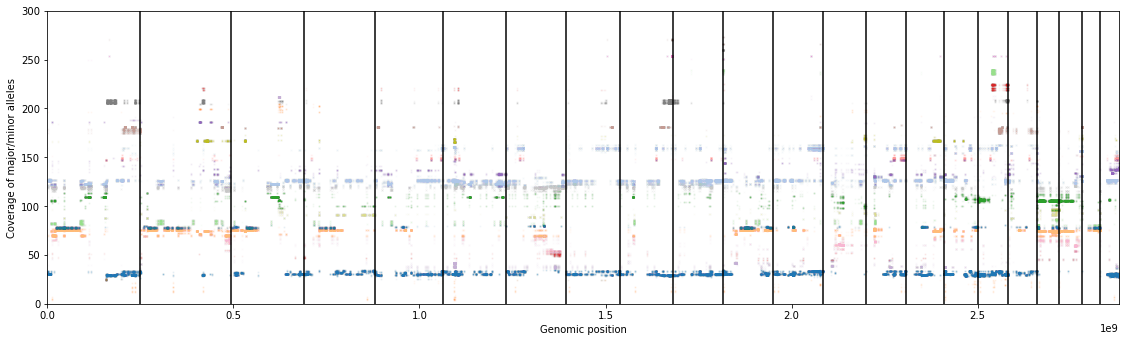

In [58]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [130]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

n unassigned: 1547
cluster 12 merging with 8
cluster 24 merging with 16
cluster 22 merging with 6
n unassigned: 1421
cluster 26 merging with 4
cluster 29 merging with 19
cluster 23 merging with 1
cluster 25 merging with 17
cluster 28 merging with 5
n unassigned: 1324
cluster 19 merging with 22
n unassigned: 1224
n unassigned: 1127
n unassigned: 1044
cluster 34 merging with 7
n unassigned: 953
n unassigned: 885
n unassigned: 811
n unassigned: 755
n unassigned: 703
n unassigned: 650
n unassigned: 605
n unassigned: 550
cluster 36 merging with 17
n unassigned: 519
n unassigned: 479
n unassigned: 443
n unassigned: 411
n unassigned: 383
cluster 37 merging with 23
cluster 38 merging with 22
n unassigned: 360
n unassigned: 336
cluster 39 merging with 23
n unassigned: 312
n unassigned: 285
cluster 40 merging with 22
n unassigned: 269
cluster 41 merging with 22
n unassigned: 242
n unassigned: 220
n unassigned: 204
n unassigned: 191
n unassigned: 174
n unassigned: 162
cluster 42 merging with 16
n

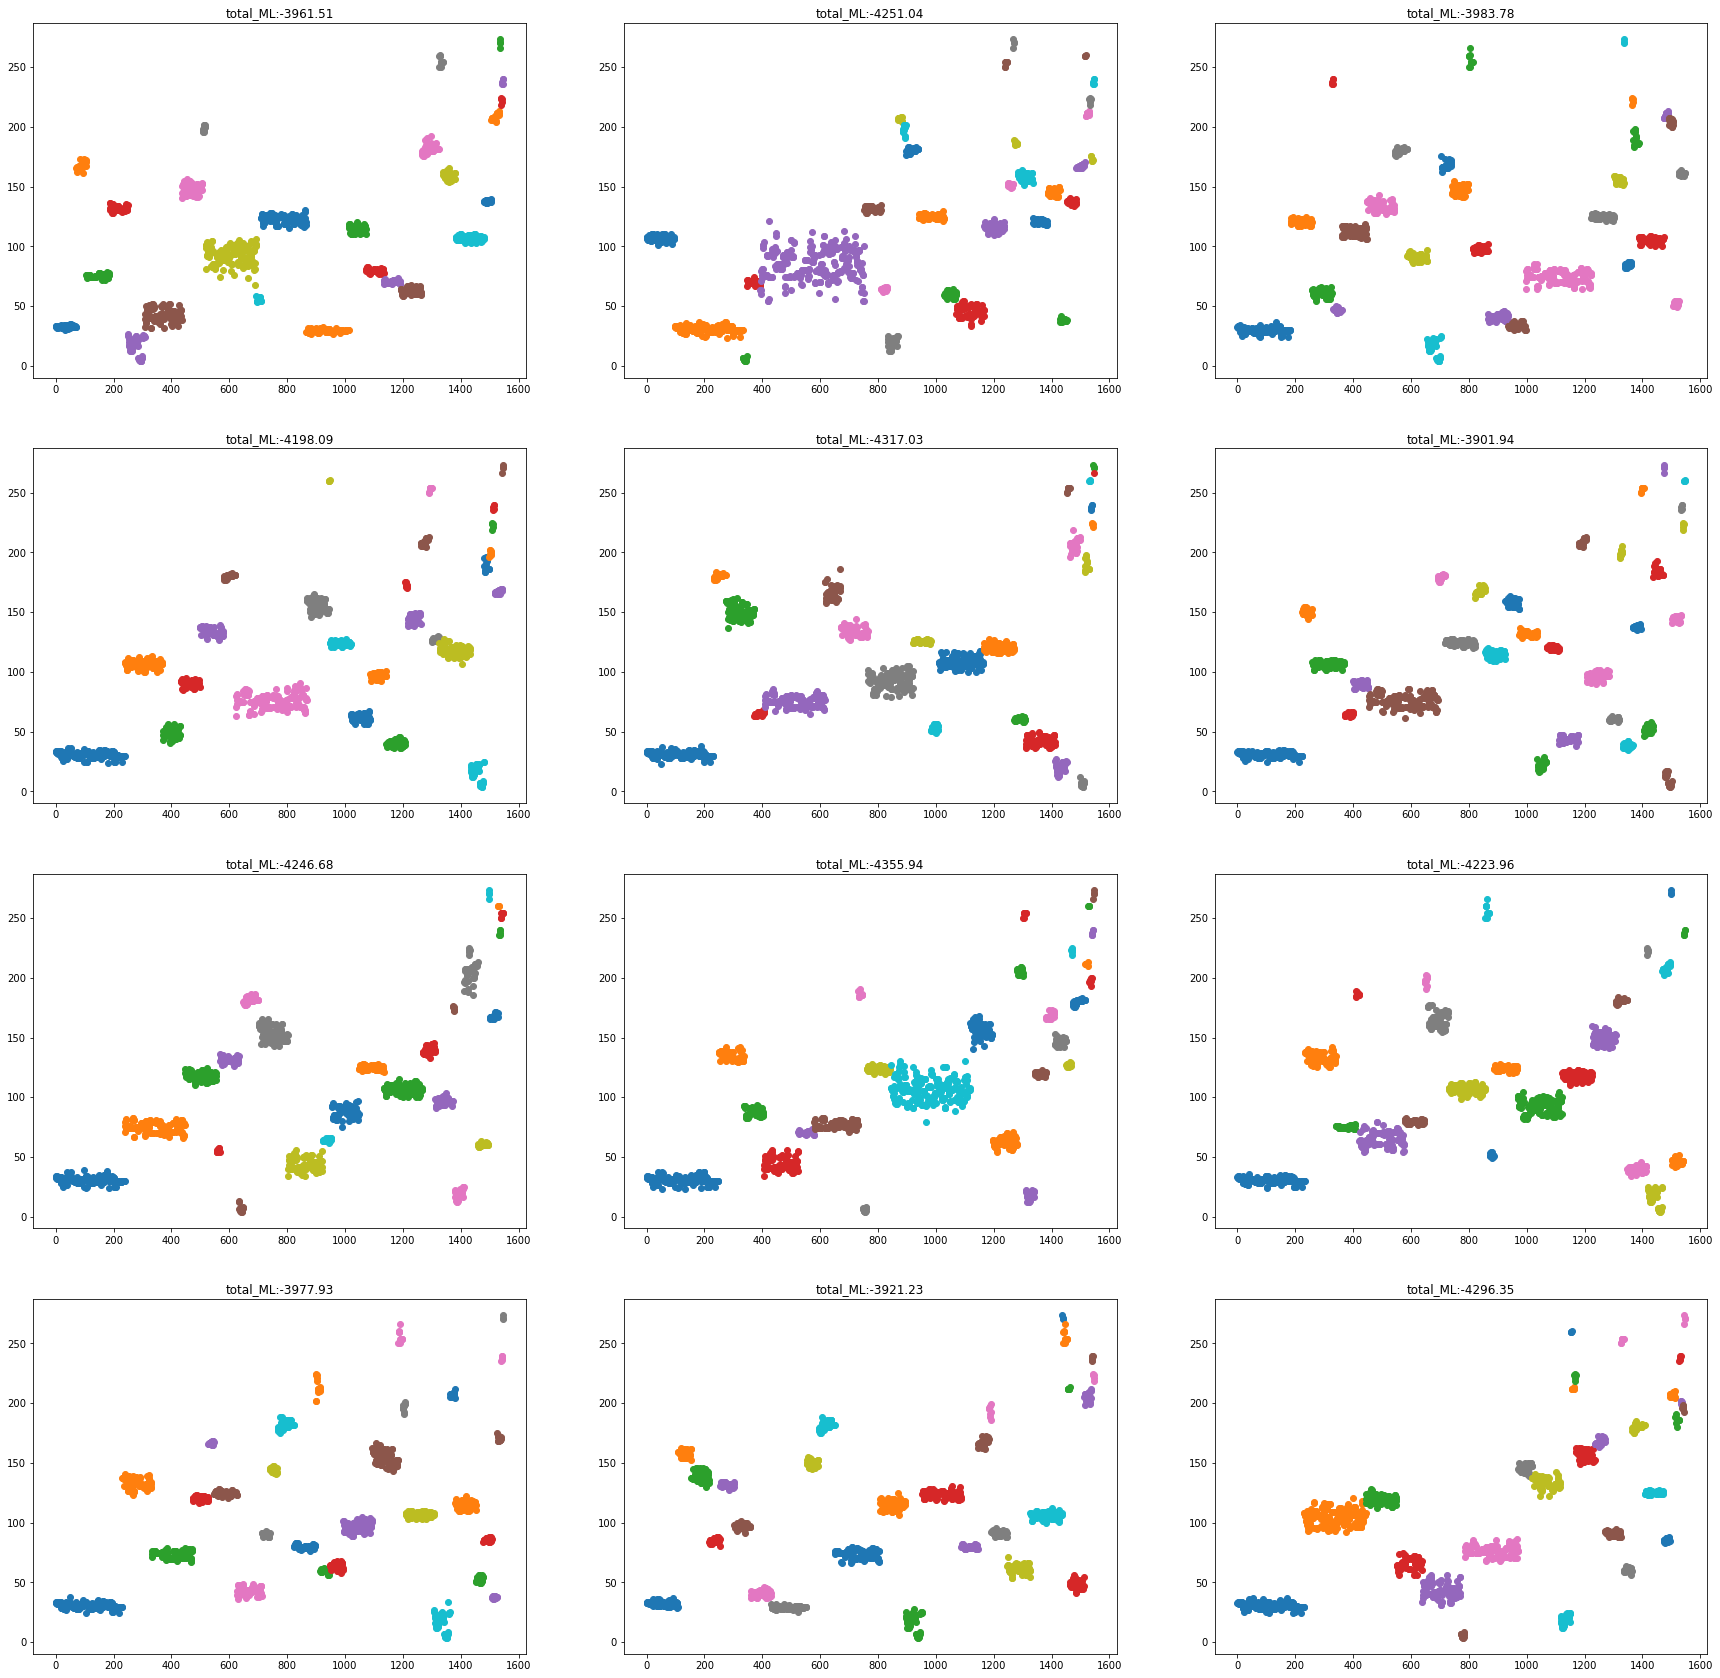

In [131]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [132]:
a_cov_dp = best_a_cov_dp

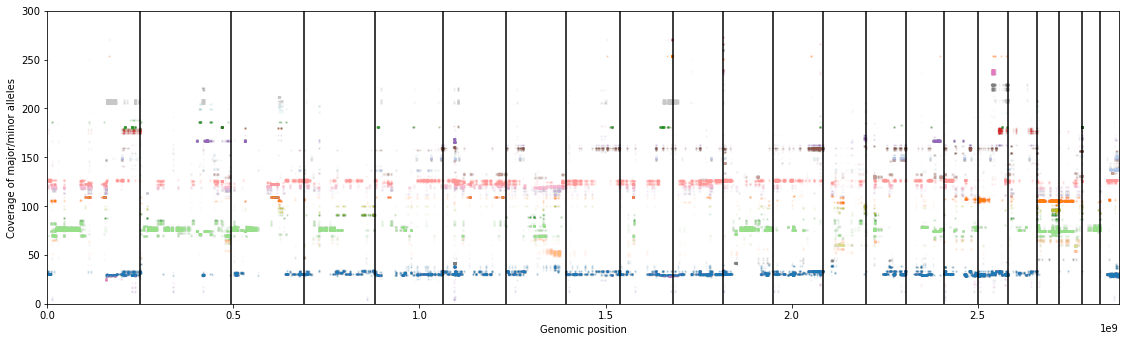

In [ ]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

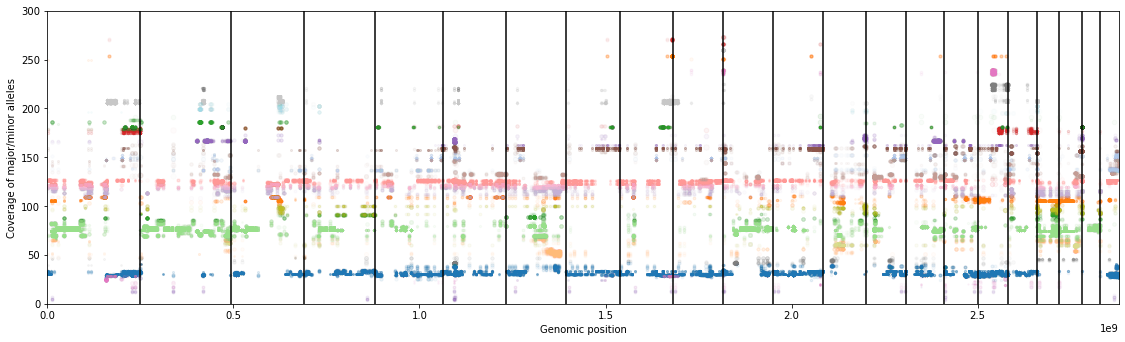

In [147]:
##attempt at variance plot
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu','cov_DP_sigma', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        if x.allele.values[0] == -1:
            a = minor; b= major
        else:
            a = major;b=minor
        
        var = (np.exp(stats.norm.rvs(x['cov_DP_mu'].values[0], x['cov_DP_sigma'].values[0], size=10000)) * stats.beta.rvs(a,b, size=10000)).var()
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.04 - (np.log(var)/2)/100,
            
            s=(np.log(var)/2 +5)**2.4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [299]:
V1_list = []
V2_list = []
r_list = []
name_list = []
glen_list = []
fallback_counts = sc.SortedDict({})
for ID, (name, grouped) in enumerate(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw'])):
    mu = grouped['cov_DP_mu'].values[0]
    sigma = grouped['cov_DP_sigma'].values[0]
    group_len = len(grouped)
    if group_len > 10:
        major, minor =  (grouped['maj_count'].sum(), grouped['min_count'].sum())
    else:
        ADP_clust = grouped['allelic_cluster'].values[0]
        if ADP_clust in fallback_counts:
            major, minor = fallback_counts[ADP_clust]
        else:
            filt = a_cov_dp.cov_df.loc[a_cov_dp.cov_df.allelic_cluster == ADP_clust]
            major, minor = filt['maj_count'].sum(), filt['min_count'].sum()
            fallback_counts[ADP_clust] = (major, minor)

    allele = grouped.allele.values[0]

    if allele== -1:
        f = minor / (minor + major)
        a = minor; b= major
    else:
        f =  major / (minor + major)
        a = major;b=minor
        
    r = np.exp(mu) * f
    r_list.append(r)
    
    C = np.c_[np.log(grouped["C_len"]), grouped["C_RT_z"], grouped["C_GC_z"]]
    x = grouped['covcorr'].values

    V1 = np.exp(np.log(x) - mu - (C @ a_cov_dp.beta).flatten()).var()
    V2 = (np.exp(stats.norm.rvs(mu, sigma, size=10000)) * stats.beta.rvs(a,b, size=10000)).var()
    
    name_list.append(name)
    V1_list.append(V1)
    V2_list.append(V2)
    glen_list.append(group_len)

In [121]:
np.log(100)

4.605170185988092

In [301]:
var_df = pd.DataFrame({'r':r_list, 'V1':V1_list, 'V2':V2_list, 'glen':glen_list}, index=pd.MultiIndex.from_tuples(name_list, names=['ADP', 'CDP', 'allele', 'dp_draw']))

In [302]:
var_df

r        V1        V2  glen
ADP CDP allele dp_draw                                      
0   0   -1     0         33.069894  0.040220  0.139890    85
               1         33.724506  0.035659  0.065867   185
               2         32.634887  0.031547  0.079828   162
               3         32.395408  0.029184  0.142630    92
               4         31.923877  0.029168  0.083558   153
...                            ...       ...       ...   ...
18  11   1     4        271.314452  0.028126  0.460298    29
               5        254.161478  0.035535  0.317716    41
               6        254.161478  0.035535  0.323840    41
               7        254.161478  0.035535  0.326732    41
               8        254.161478  0.035535  0.322738    41

[1592 rows x 4 columns]

In [482]:
var_df.V2.min()

0.000368764312635159

In [346]:
var_df.loc[(0,15,-1)]

,r,V1,V2,glen
dp_draw,,,,
1,29.089422,0.890691,36.071718,2


In [275]:
np.sqrt(0.07)

0.2645751311064591

In [345]:
var_df.loc[(4,11,1)]

,r,V1,V2,glen
dp_draw,,,,
0,181.30666,0.024887,0.440491,65
1,181.30666,0.024887,0.430705,65
2,181.30666,0.024887,0.413155,65
3,181.30666,0.024887,0.422752,65
4,181.30666,0.024887,0.421326,65
5,181.30666,0.024887,0.424588,65
6,181.30666,0.024887,0.434697,65
7,181.30666,0.024887,0.419580,65
8,181.30666,0.024887,0.426071,65


In [338]:
r_vars = []
v2_means = []
names = []
for name, group in var_df.groupby(level=['ADP','CDP', 'allele']):
    if len(group) > 7 and group.glen.mean() > 50 and name[2]==1:
        print(name, group.r.var())
        names.append(name)
        r_vars.append(group.r.var())
        v2_means.append(group.V2.mean())

(0, 0, 1) 3.1668705138217
(0, 1, 1) 1.7690600123231293
(1, 5, 1) 0.027973239615820347
(1, 7, 1) 4.551367943672367
(1, 8, 1) 0.15308465398080945
(3, 3, 1) 2.312367741136457
(3, 6, 1) 2.9083023852125134
(3, 12, 1) 5.393083394514547
(4, 0, 1) 3.9763709700422476
(4, 1, 1) 8.757512237437702
(4, 7, 1) 0.09300638491654849
(4, 11, 1) 0.0
(5, 2, 1) 17.223902681445562
(5, 3, 1) 0.11484832039977783
(5, 8, 1) 9.015423212173209
(6, 2, 1) 70.67297416337479
(6, 8, 1) 2.17320717217706
(7, 8, 1) 0.022622824236098446
(8, 0, 1) 2.0792777303705603
(8, 1, 1) 0.7879022255227182
(8, 7, 1) 6.534611356624484
(9, 5, 1) 0.1245534556257315
(9, 6, 1) 13.943026458734177
(9, 12, 1) 6.1773519219616215
(11, 6, 1) 0.07088124904878226
(11, 12, 1) 1.6549559528183837
(12, 7, 1) 15.371348587867594
(15, 7, 1) 2.747635210910639
(16, 0, 1) 8.97548407718129e-28


In [340]:
np.array(r_vars).mean()

6.26977662068845

(-10.0, 10.0)

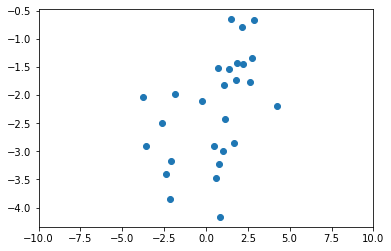

In [327]:
plt.scatter(np.log(r_vars), np.log(v2_means))
plt.xlim([-10,10])

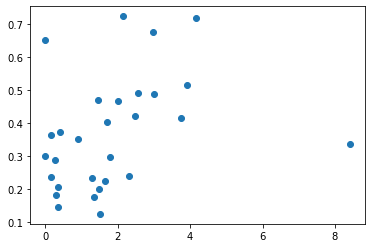

In [332]:
plt.scatter(np.sqrt(r_vars), np.sqrt(v2_means))

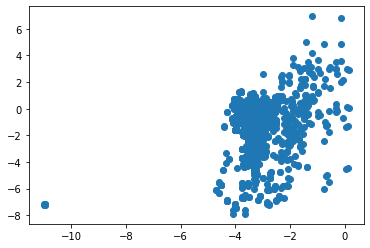

In [154]:
plt.scatter(np.log(np.array(V1_list)), np.log(np.array(V2_list)))

(array([ 57.,  55., 131., 340., 539., 384.,  54.,  26.,   4.,   2.]),
 array([-7.89832654, -6.4140387 , -4.92975086, -3.44546302, -1.96117517,
        -0.47688733,  1.00740051,  2.49168835,  3.9759762 ,  5.46026404,
         6.94455188]),
 <BarContainer object of 10 artists>)

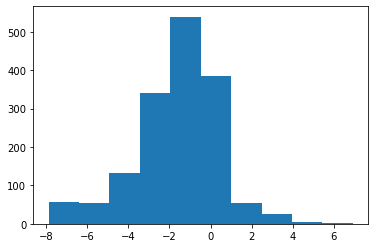

In [134]:
plt.hist(np.log(np.array(V2_list)))

CPU times: user 70.9 ms, sys: 0 ns, total: 70.9 ms
Wall time: 68.7 ms


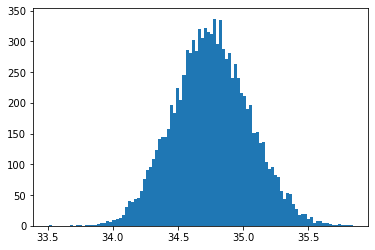

In [ ]:
%%time
#ADP 0, CDP 11
_ =plt.hist(np.exp(stats.norm.rvs(4.901, 0.000306, size=10000)) * (stats.beta.rvs(10109,28989, size=10000)), bins = 100)

In [ ]:
#testing out V2 variance

In [204]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [205]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [206]:
a_cov_dp.run(1)

n unassigned: 1547
cluster 1 merging with 9
cluster 16 merging with 12
cluster 26 merging with 1
cluster 17 merging with 29
cluster 19 merging with 11
n unassigned: 1426
cluster 39 merging with 16
cluster 41 merging with 26
cluster 42 merging with 9
cluster 43 merging with 31
cluster 22 merging with 3
n unassigned: 1311
cluster 47 merging with 17
cluster 50 merging with 36
cluster 49 merging with 4
n unassigned: 1198
n unassigned: 1106
cluster 55 merging with 34
cluster 36 merging with 35
cluster 56 merging with 9
n unassigned: 1021
n unassigned: 952
cluster 54 merging with 35
cluster 57 merging with 35
n unassigned: 887
cluster 61 merging with 32
n unassigned: 809
n unassigned: 742
n unassigned: 689
n unassigned: 636
n unassigned: 581
n unassigned: 531
n unassigned: 492
n unassigned: 455
cluster 64 merging with 43
n unassigned: 421
n unassigned: 385
n unassigned: 347
n unassigned: 319
n unassigned: 285
n unassigned: 259
n unassigned: 238
cluster 58 merging with 36
cluster 65 merging w

([array([ 0,  0,  0, ..., 48, 48, 48])],
 SortedDict({0: 82, 1: 25, 2: 104, 3: 65, 4: 44, 5: 62, 6: 32, 7: 68, 8: 71, 10: 76, 11: 30, 12: 75, 14: 35, 15: 2, 16: 116, 17: 16, 18: 37, 20: 71, 21: 67, 23: 28, 24: 4, 25: 6, 27: 30, 28: 60, 29: 22, 31: 3, 33: 46, 34: 16, 35: 5, 38: 36, 40: 31, 41: 21, 43: 18, 44: 23, 45: 26, 46: 27, 48: 10, 51: 38, 52: 6, 53: 3, 59: 2, 62: 4, 63: 6}))

In [198]:
len(a_cov_dp.cluster_dict)

58

In [199]:
a_cov_dp.ML_total_history[-1]

-3157.454216225563

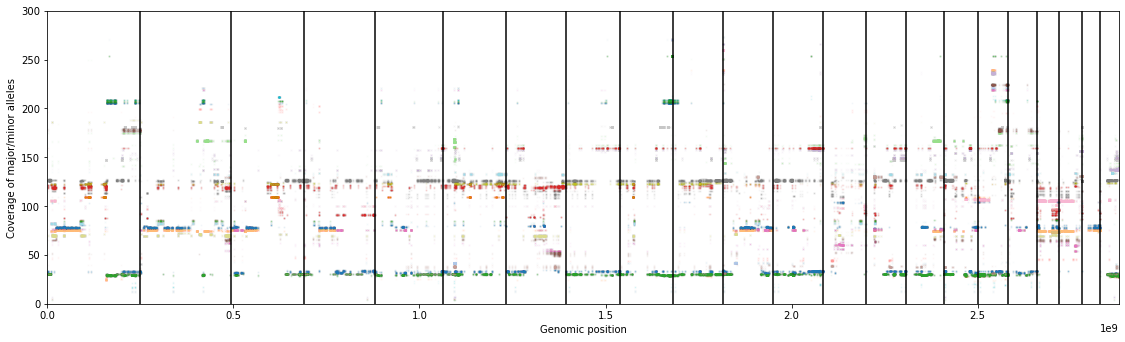

In [200]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

n unassigned: 1547
cluster 9 merging with 0
cluster 23 merging with 8
cluster 21 merging with 14
cluster 26 merging with 2
cluster 33 merging with 10
n unassigned: 1434
cluster 22 merging with 14
cluster 38 merging with 2
n unassigned: 1319
cluster 45 merging with 36
cluster 47 merging with 13
cluster 42 merging with 4
cluster 39 merging with 8
n unassigned: 1234
cluster 49 merging with 1
cluster 44 merging with 28
cluster 50 merging with 4
n unassigned: 1137
cluster 54 merging with 2
n unassigned: 1048
cluster 52 merging with 12
n unassigned: 955
n unassigned: 877
cluster 57 merging with 38
n unassigned: 803
n unassigned: 747
n unassigned: 693
cluster 51 merging with 7
n unassigned: 640
n unassigned: 591
n unassigned: 541
cluster 60 merging with 37
n unassigned: 505
cluster 61 merging with 30
n unassigned: 469
n unassigned: 432
n unassigned: 400
n unassigned: 363
n unassigned: 331
n unassigned: 304
n unassigned: 279
n unassigned: 257
n unassigned: 235
cluster 58 merging with 38
n unas

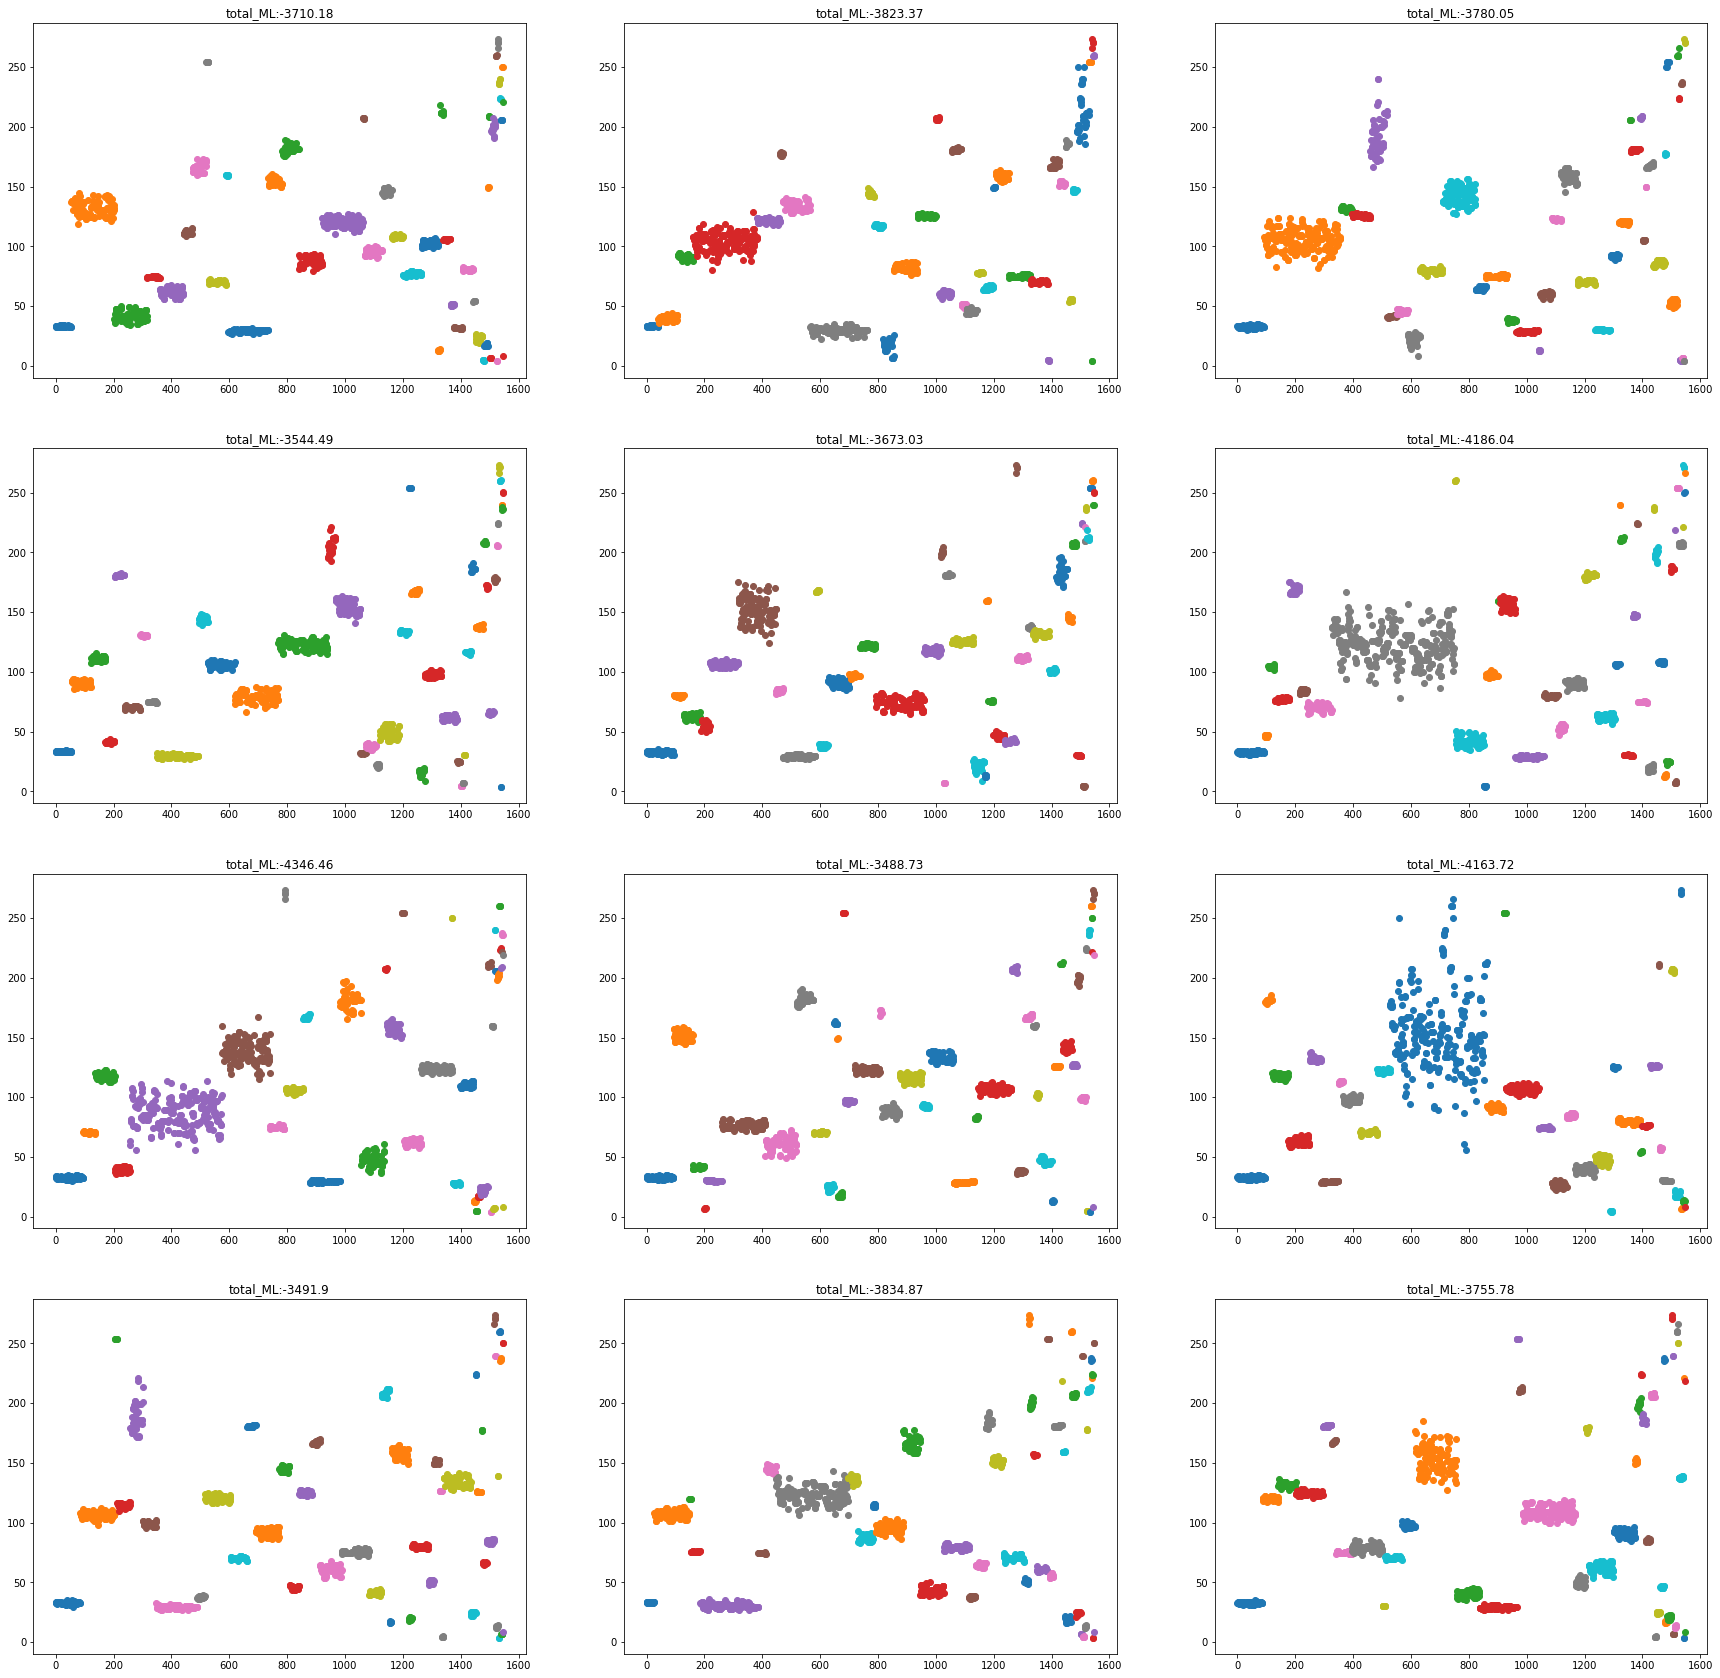

In [210]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

(array([ 22.,  44.,  43.,  53., 118., 206., 280., 358., 281., 187.]),
 array([-1.65639926, -1.1911861 , -0.72597295, -0.2607598 ,  0.20445335,
         0.66966651,  1.13487966,  1.60009281,  2.06530597,  2.53051912,
         2.99573227]),
 <BarContainer object of 10 artists>)

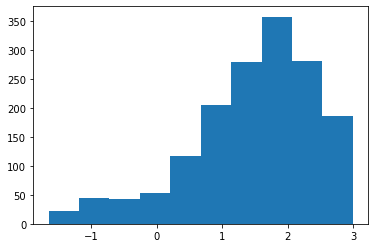

In [259]:
plt.hist(np.log(np.array(a_cov_dp.segment_V_list)))

(array([ 31.,  55.,  41.,  99., 214., 333., 407., 309.,  57.,  46.]),
 array([-3.95536216, -3.41003933, -2.8647165 , -2.31939367, -1.77407084,
        -1.22874801, -0.68342518, -0.13810235,  0.40722048,  0.95254331,
         1.49786614]),
 <BarContainer object of 10 artists>)

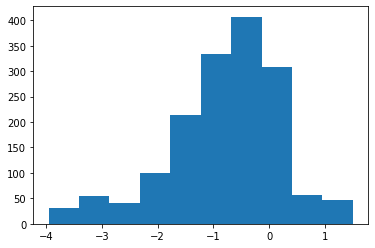

In [226]:
plt.hist(np.log(np.sqrt(np.array(a_cov_dp.segment_V_list))))

(array([727., 489., 224.,  73.,  26.,   9.,   9.,   4.,   6.,  25.]),
 array([ 0.0520598 ,  1.26250641,  2.47295302,  3.68339963,  4.89384624,
         6.10429285,  7.31473946,  8.52518607,  9.73563268, 10.94607929,
        12.1565259 ]),
 <BarContainer object of 10 artists>)

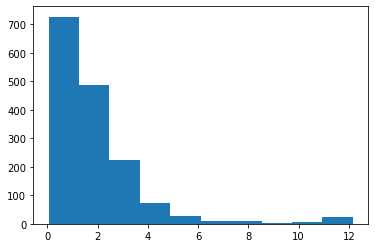

In [228]:
plt.hist(np.exp(np.log(np.sqrt(np.array(a_cov_dp.segment_V_list)))+ 1))

In [218]:
np.exp(3)

20.085536923187668

trying out seeding with low variance tuples. alpha =10, beta = alpha * Vscale

In [214]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

n unassigned: 1547
cluster 10 merging with 0
cluster 6 merging with 10
cluster 9 merging with 10
cluster 24 merging with 0
n unassigned: 1486
n unassigned: 1440
cluster 48 merging with 6
n unassigned: 1400
cluster 52 merging with 46
cluster 25 merging with 55
cluster 46 merging with 21
n unassigned: 1362
cluster 38 merging with 42
cluster 62 merging with 49
cluster 64 merging with 44
cluster 44 merging with 44
cluster 71 merging with 40
cluster 36 merging with 40
cluster 39 merging with 50
cluster 37 merging with 43
n unassigned: 1255
cluster 80 merging with 9
cluster 42 merging with 15
cluster 30 merging with 30
cluster 59 merging with 48
cluster 78 merging with 44
cluster 77 merging with 34
cluster 73 merging with 38
n unassigned: 1170
cluster 82 merging with 2
cluster 22 merging with 52
n unassigned: 1073
cluster 63 merging with 43
cluster 86 merging with 41
cluster 40 merging with 56
n unassigned: 988
cluster 88 merging with 4
cluster 89 merging with 7
n unassigned: 909
n unassigne

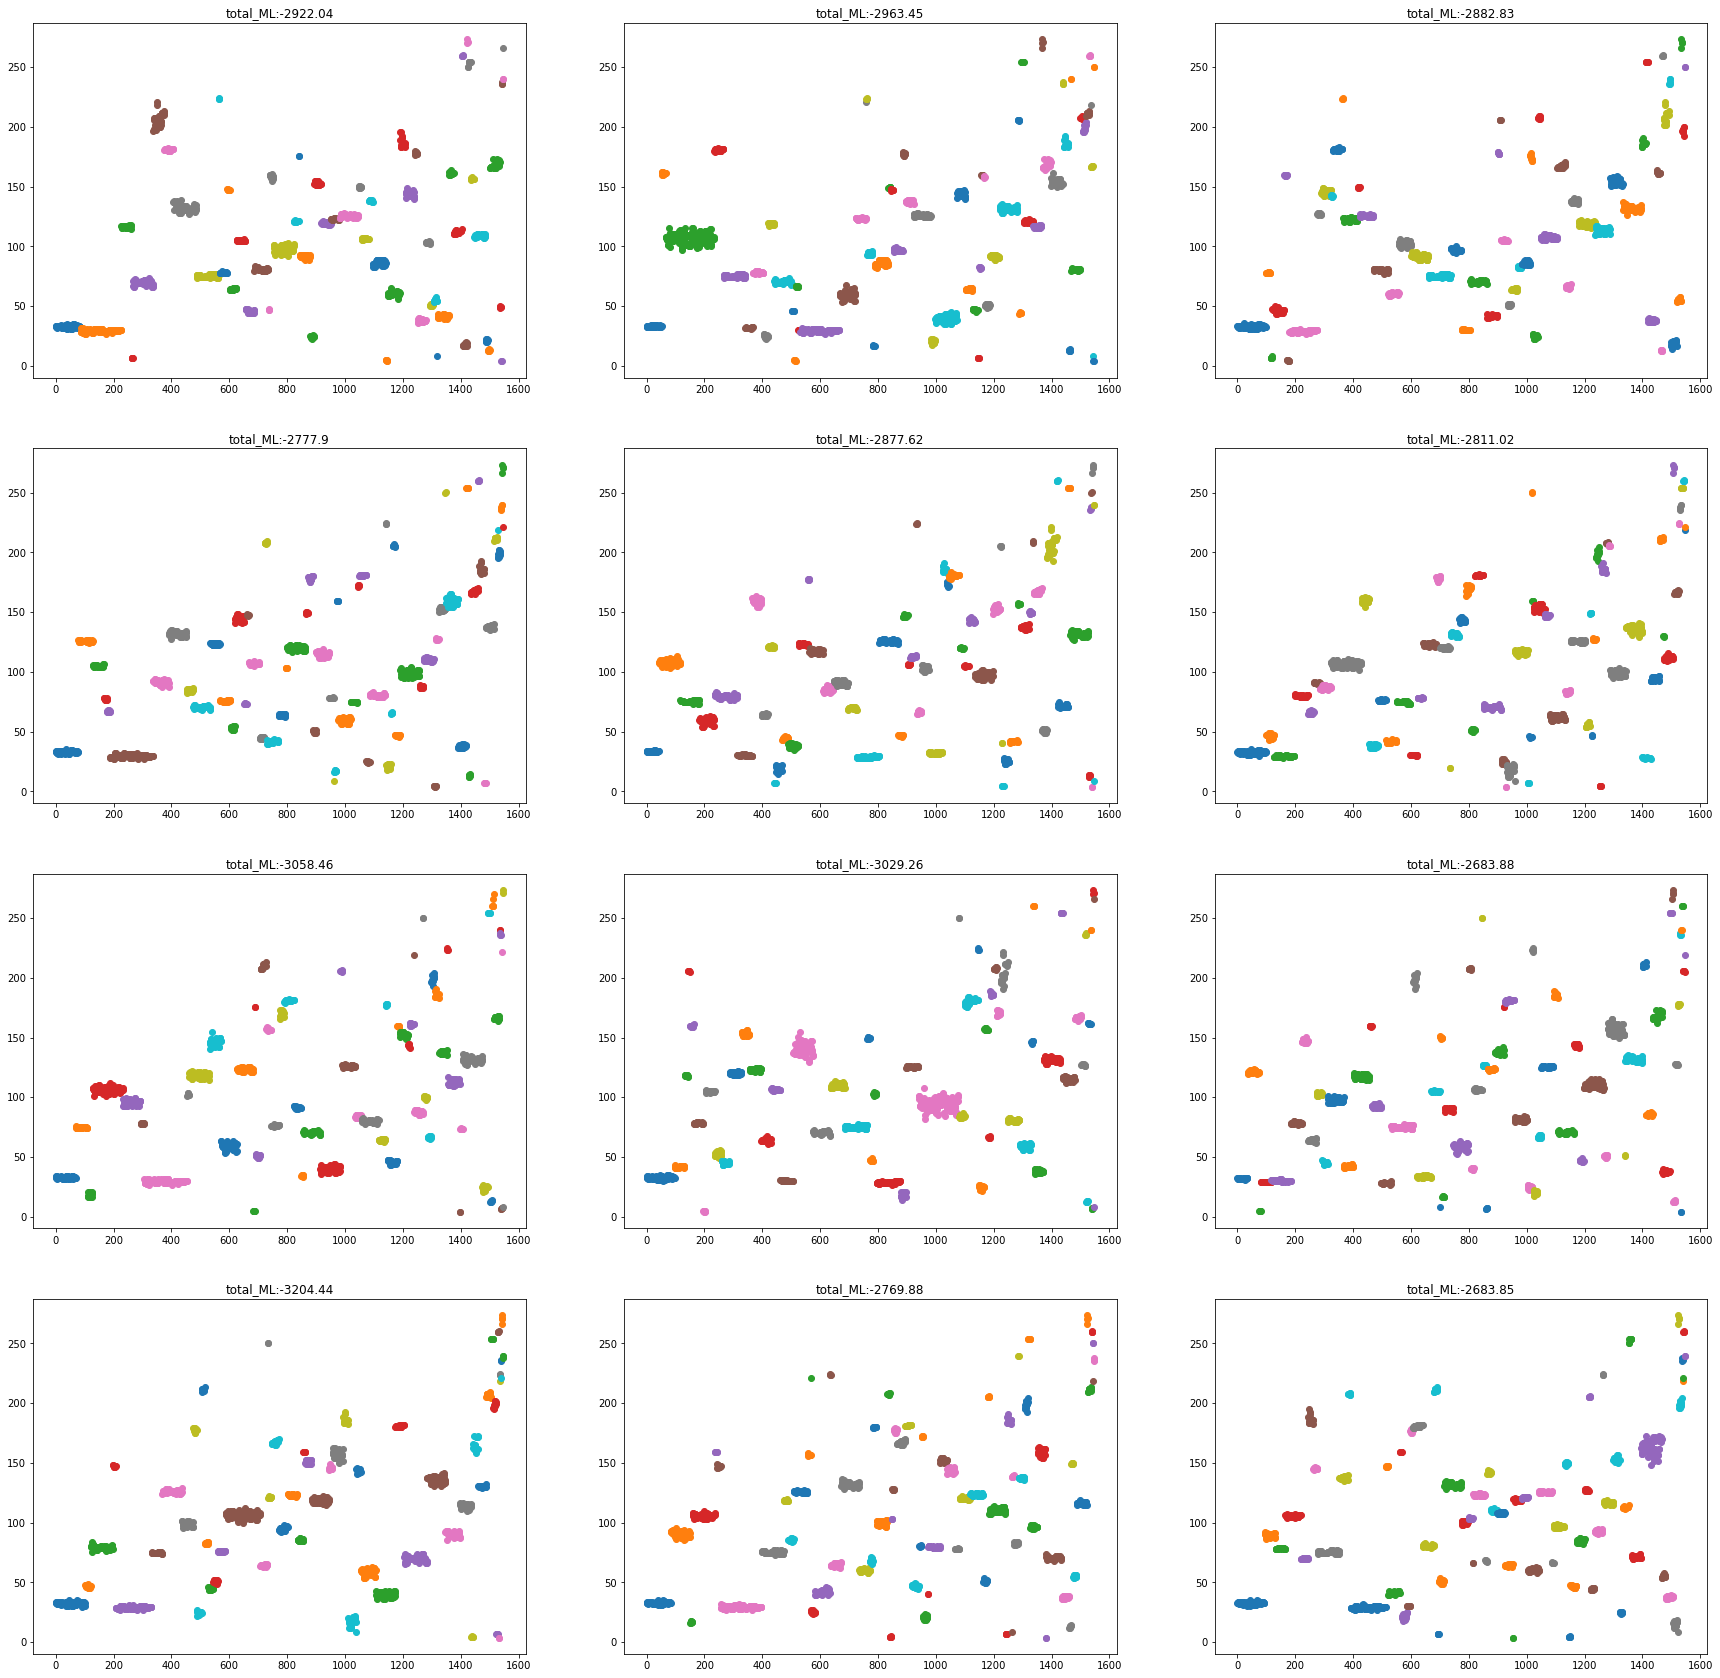

In [215]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

alpha = max(5, len(r) /2), beta = alpha/2 * Vscale

In [219]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

n unassigned: 1547
cluster 18 merging with 8
cluster 13 merging with 10
cluster 1 merging with 6
cluster 12 merging with 5
cluster 7 merging with 23
cluster 34 merging with 19
cluster 29 merging with 9
n unassigned: 1436
cluster 37 merging with 19
cluster 35 merging with 5
cluster 26 merging with 19
cluster 33 merging with 5
cluster 36 merging with 2
cluster 19 merging with 8
cluster 42 merging with 2
cluster 41 merging with 10
n unassigned: 1316
cluster 2 merging with 2
cluster 47 merging with 4
cluster 45 merging with 8
n unassigned: 1225
n unassigned: 1135
cluster 54 merging with 8
cluster 53 merging with 7
n unassigned: 1029
cluster 56 merging with 10
cluster 43 merging with 33
cluster 57 merging with 4
n unassigned: 941
n unassigned: 875
cluster 59 merging with 7
cluster 61 merging with 15
cluster 60 merging with 7
n unassigned: 801
cluster 58 merging with 7
cluster 62 merging with 8
n unassigned: 729
cluster 32 merging with 27
cluster 63 merging with 26
cluster 65 merging with 4


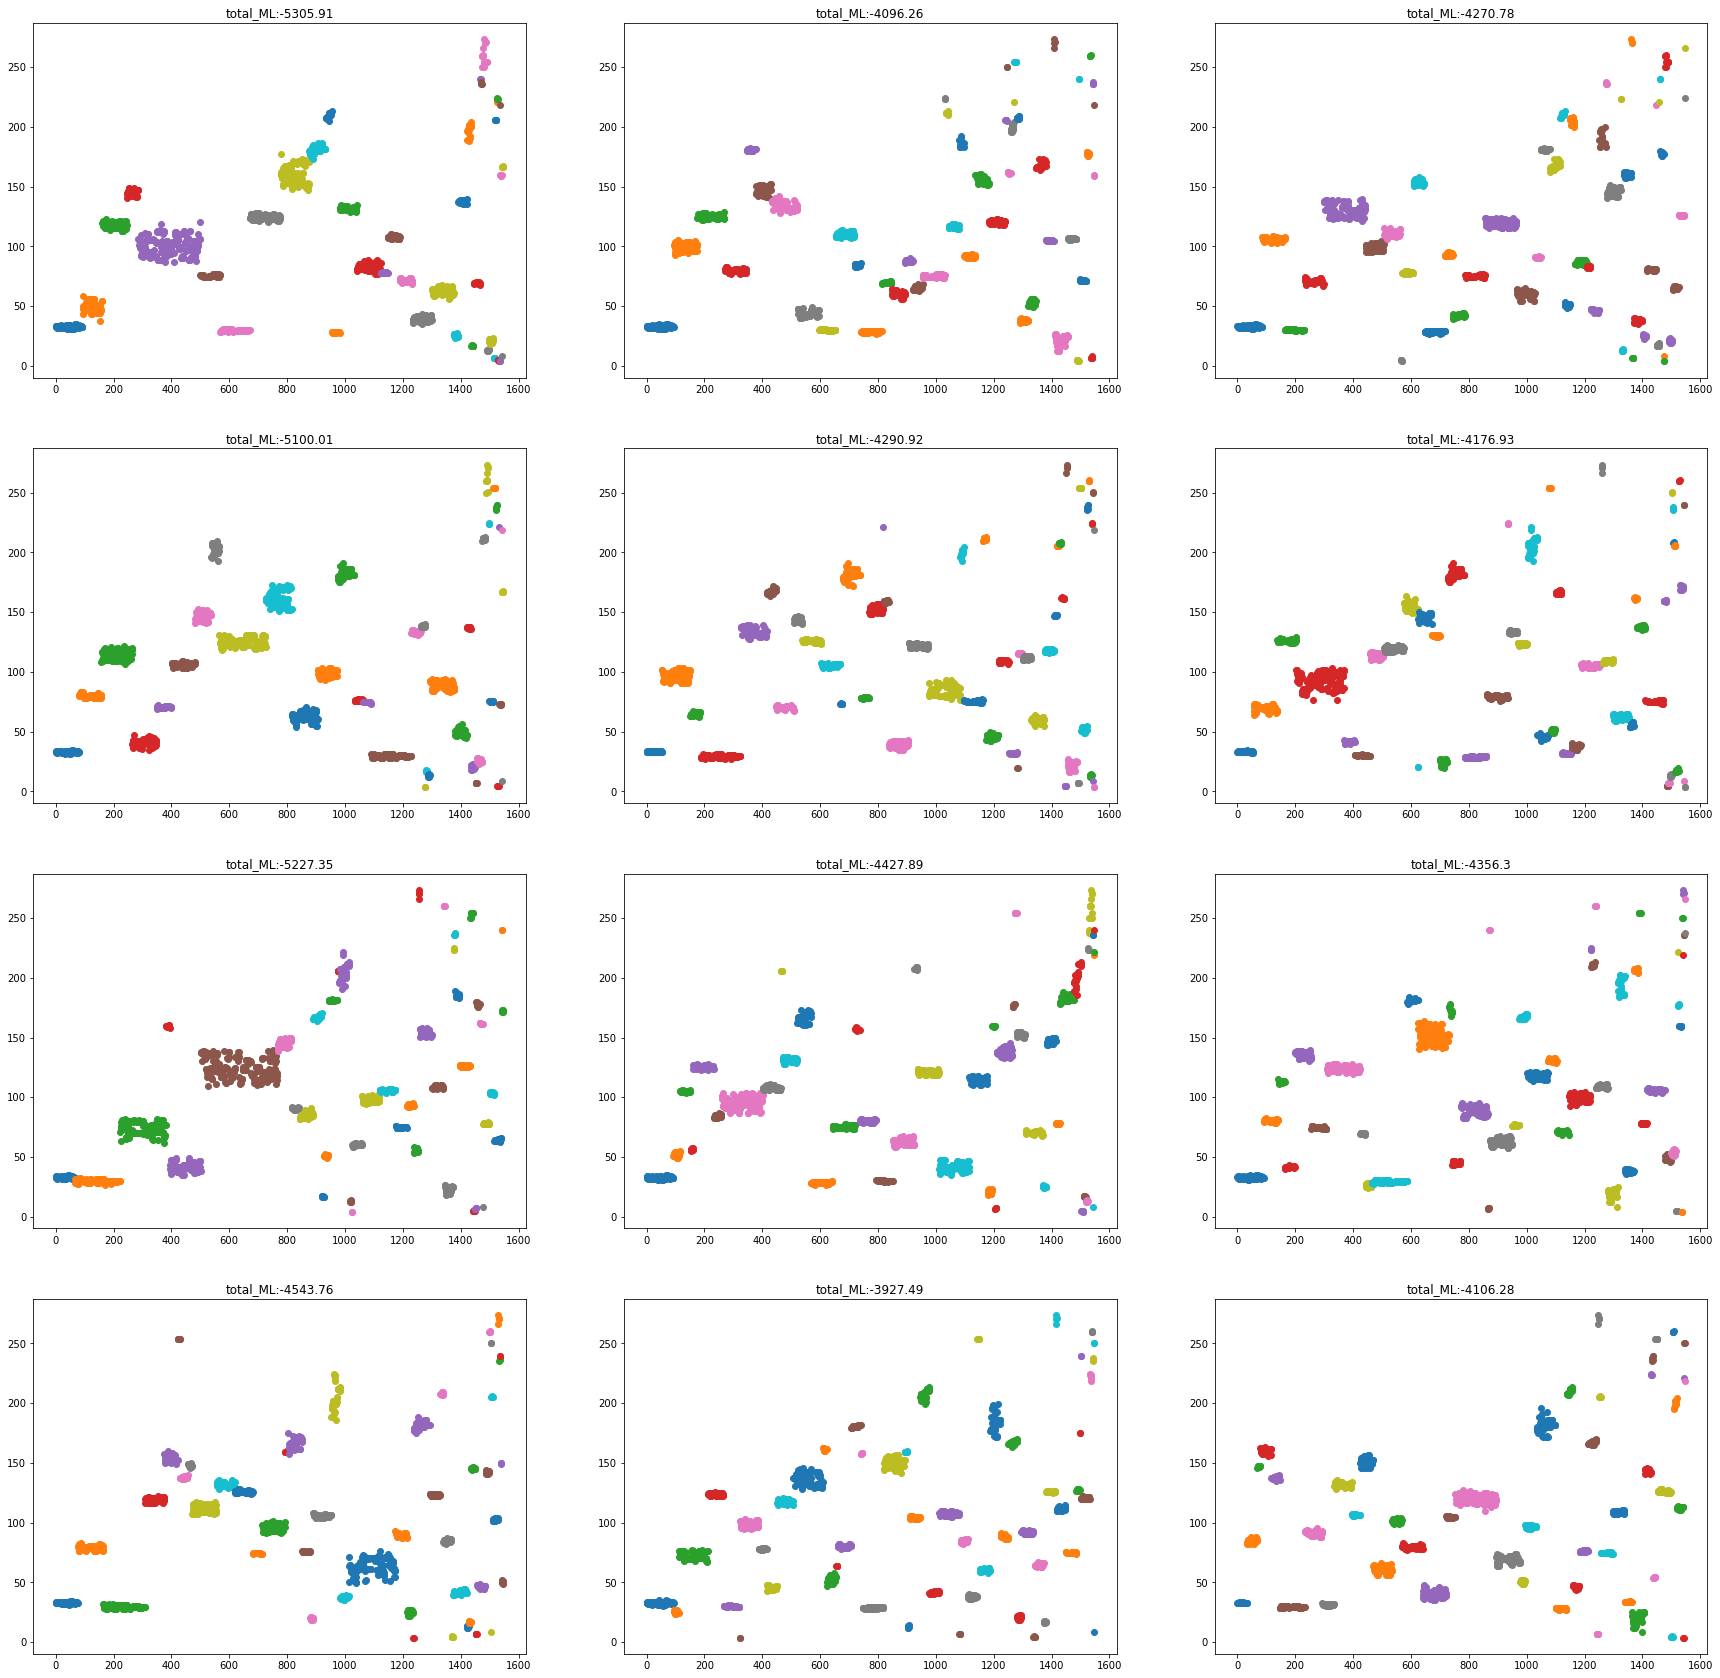

In [220]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

alpha = max(10, len(r) /2), beta = alpha * Vscale

In [221]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

n unassigned: 1547
cluster 18 merging with 10
cluster 13 merging with 8
cluster 39 merging with 1
n unassigned: 1426
cluster 38 merging with 37
cluster 35 merging with 21
cluster 31 merging with 23
cluster 42 merging with 8
cluster 28 merging with 32
cluster 46 merging with 13
n unassigned: 1314
cluster 49 merging with 6
cluster 51 merging with 4
cluster 53 merging with 29
cluster 54 merging with 6
cluster 45 merging with 31
n unassigned: 1212
cluster 50 merging with 20
n unassigned: 1114
cluster 47 merging with 42
cluster 60 merging with 16
cluster 59 merging with 29
cluster 32 merging with 45
cluster 56 merging with 16
n unassigned: 1033
cluster 61 merging with 15
cluster 65 merging with 40
n unassigned: 960
cluster 66 merging with 23
n unassigned: 893
cluster 67 merging with 16
n unassigned: 828
n unassigned: 771
cluster 69 merging with 31
cluster 68 merging with 29
n unassigned: 713
n unassigned: 672
cluster 70 merging with 37
cluster 48 merging with 20
n unassigned: 630
n unassign

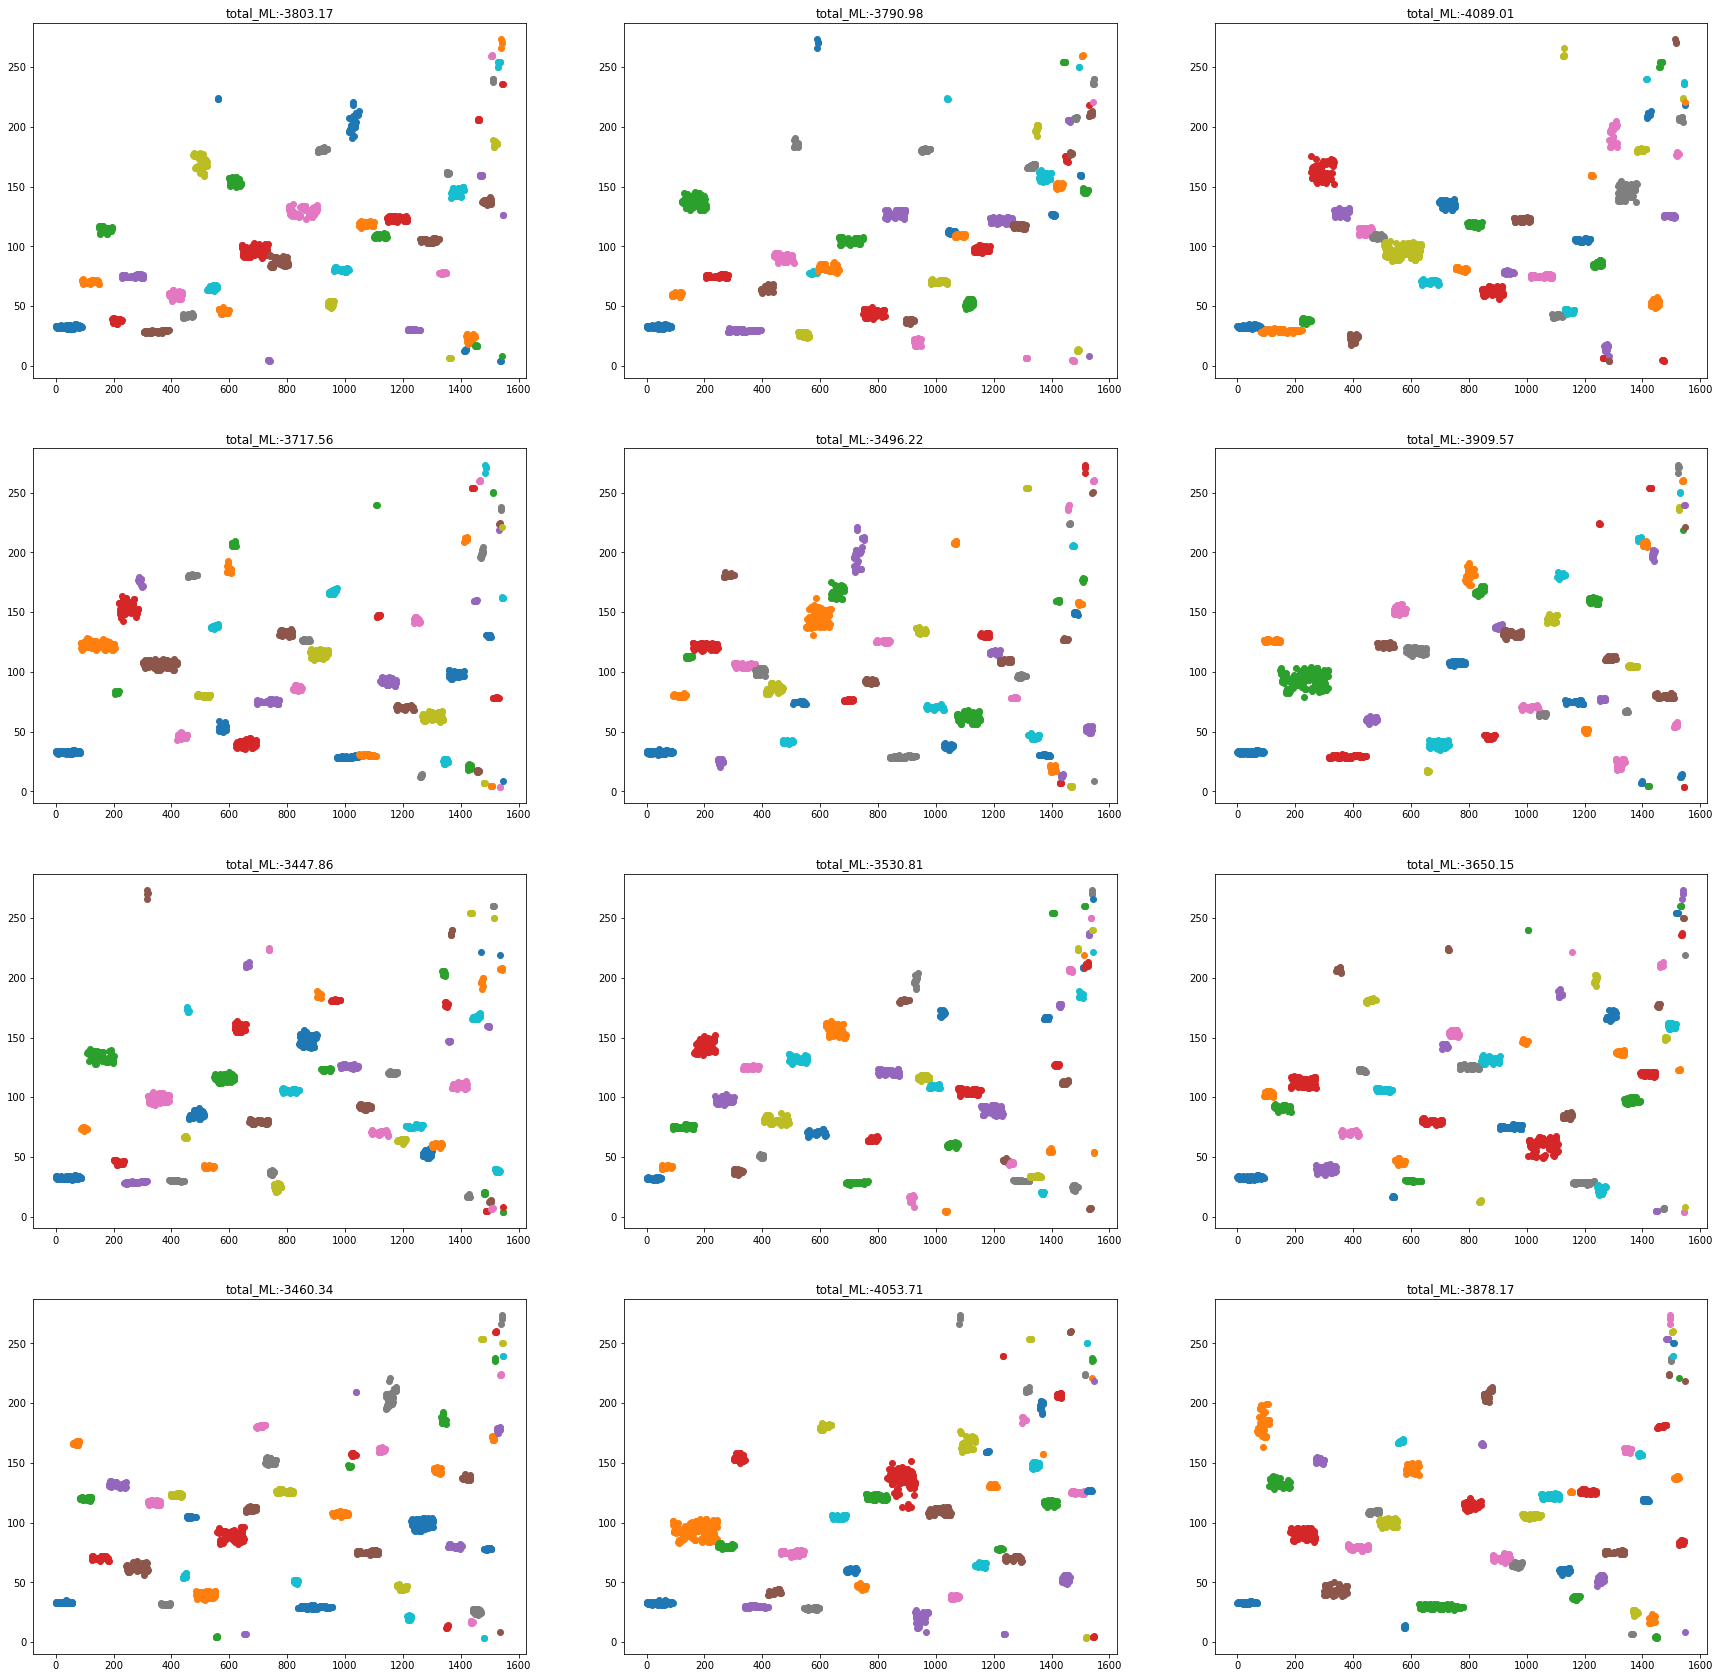

In [222]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [223]:
a_cov_dp = best_a_cov_dp

In [225]:
len(a_cov_dp.cluster_dict)

54

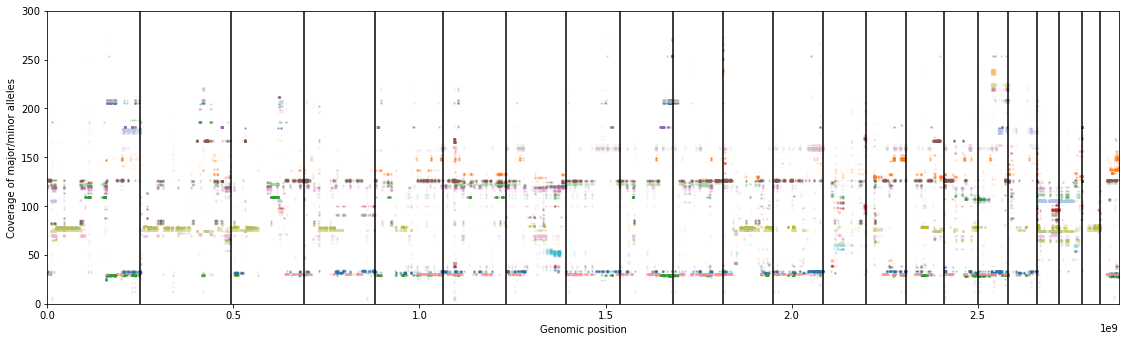

In [224]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [229]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [230]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [231]:
a_cov_dp.run(1)

n unassigned: 1547
cluster 3 merging with 4
cluster 8 merging with 3
cluster 12 merging with 3
cluster 2 merging with 6
cluster 15 merging with 0
n unassigned: 1430
cluster 20 merging with 8
n unassigned: 1327
n unassigned: 1220
n unassigned: 1126
cluster 25 merging with 10
n unassigned: 1027
n unassigned: 958
n unassigned: 877
n unassigned: 819
n unassigned: 753
n unassigned: 689
n unassigned: 642
n unassigned: 595
n unassigned: 551
n unassigned: 508
n unassigned: 460
n unassigned: 430
n unassigned: 400
n unassigned: 369
n unassigned: 339
n unassigned: 312
n unassigned: 288
n unassigned: 268
n unassigned: 247
n unassigned: 228
n unassigned: 205
n unassigned: 192
n unassigned: 179
n unassigned: 171
n unassigned: 160
n unassigned: 95
n unassigned: 30
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 0,  0,  0, ..., 10, 10, 10])],
 SortedDict({0: 219, 1: 157, 3: 220, 5: 168, 6: 142, 7: 90, 9: 58, 10: 14, 11: 57, 13: 92, 14: 54, 16: 42, 17: 54, 18: 4, 19: 118, 21: 14, 22: 37, 23: 5, 24: 4}))

In [232]:
len(a_cov_dp.cluster_dict)

19

In [233]:
a_cov_dp.ML_total_history[-1]

-4896.233959213011

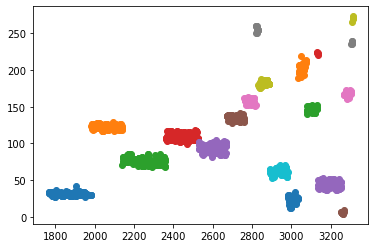

In [237]:
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

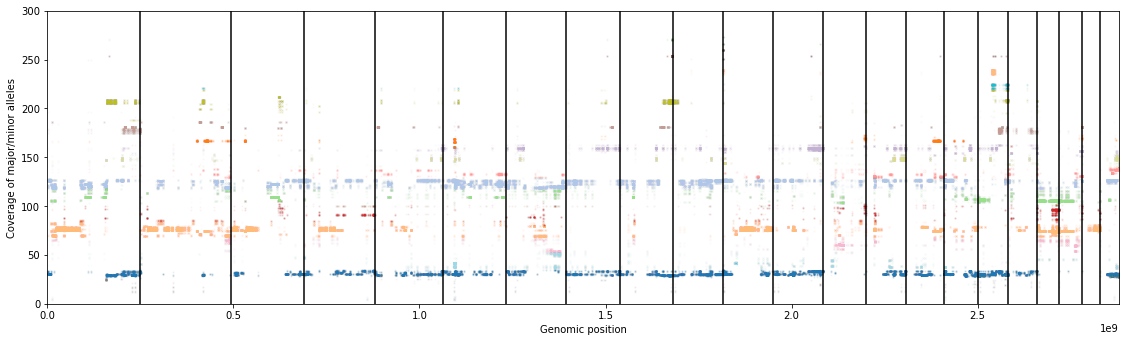

In [234]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

doing this for multiple samples

n unassigned: 1547
cluster 8 merging with 10
cluster 9 merging with 4
cluster 15 merging with 3
n unassigned: 1428
cluster 16 merging with 0
n unassigned: 1318
n unassigned: 1231
n unassigned: 1139
n unassigned: 1054
n unassigned: 976
n unassigned: 907
n unassigned: 831
n unassigned: 758
n unassigned: 699
n unassigned: 636
n unassigned: 591
n unassigned: 535
n unassigned: 484
n unassigned: 455
n unassigned: 420
n unassigned: 393
n unassigned: 355
n unassigned: 327
n unassigned: 300
n unassigned: 270
n unassigned: 248
n unassigned: 222
n unassigned: 209
n unassigned: 196
n unassigned: 171
n unassigned: 158
n unassigned: 84
n unassigned: 24
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 1547
cluster 9 merging with 8
cluster 13 merging with 7
cluster 4 merging with 11
n unassigned: 1411
n unassigned: 1304
n unassigned: 1206
n unassigned: 1106
n unassigned: 1011
n unassigned: 929
n unassigned: 868
cluster 21 merging with

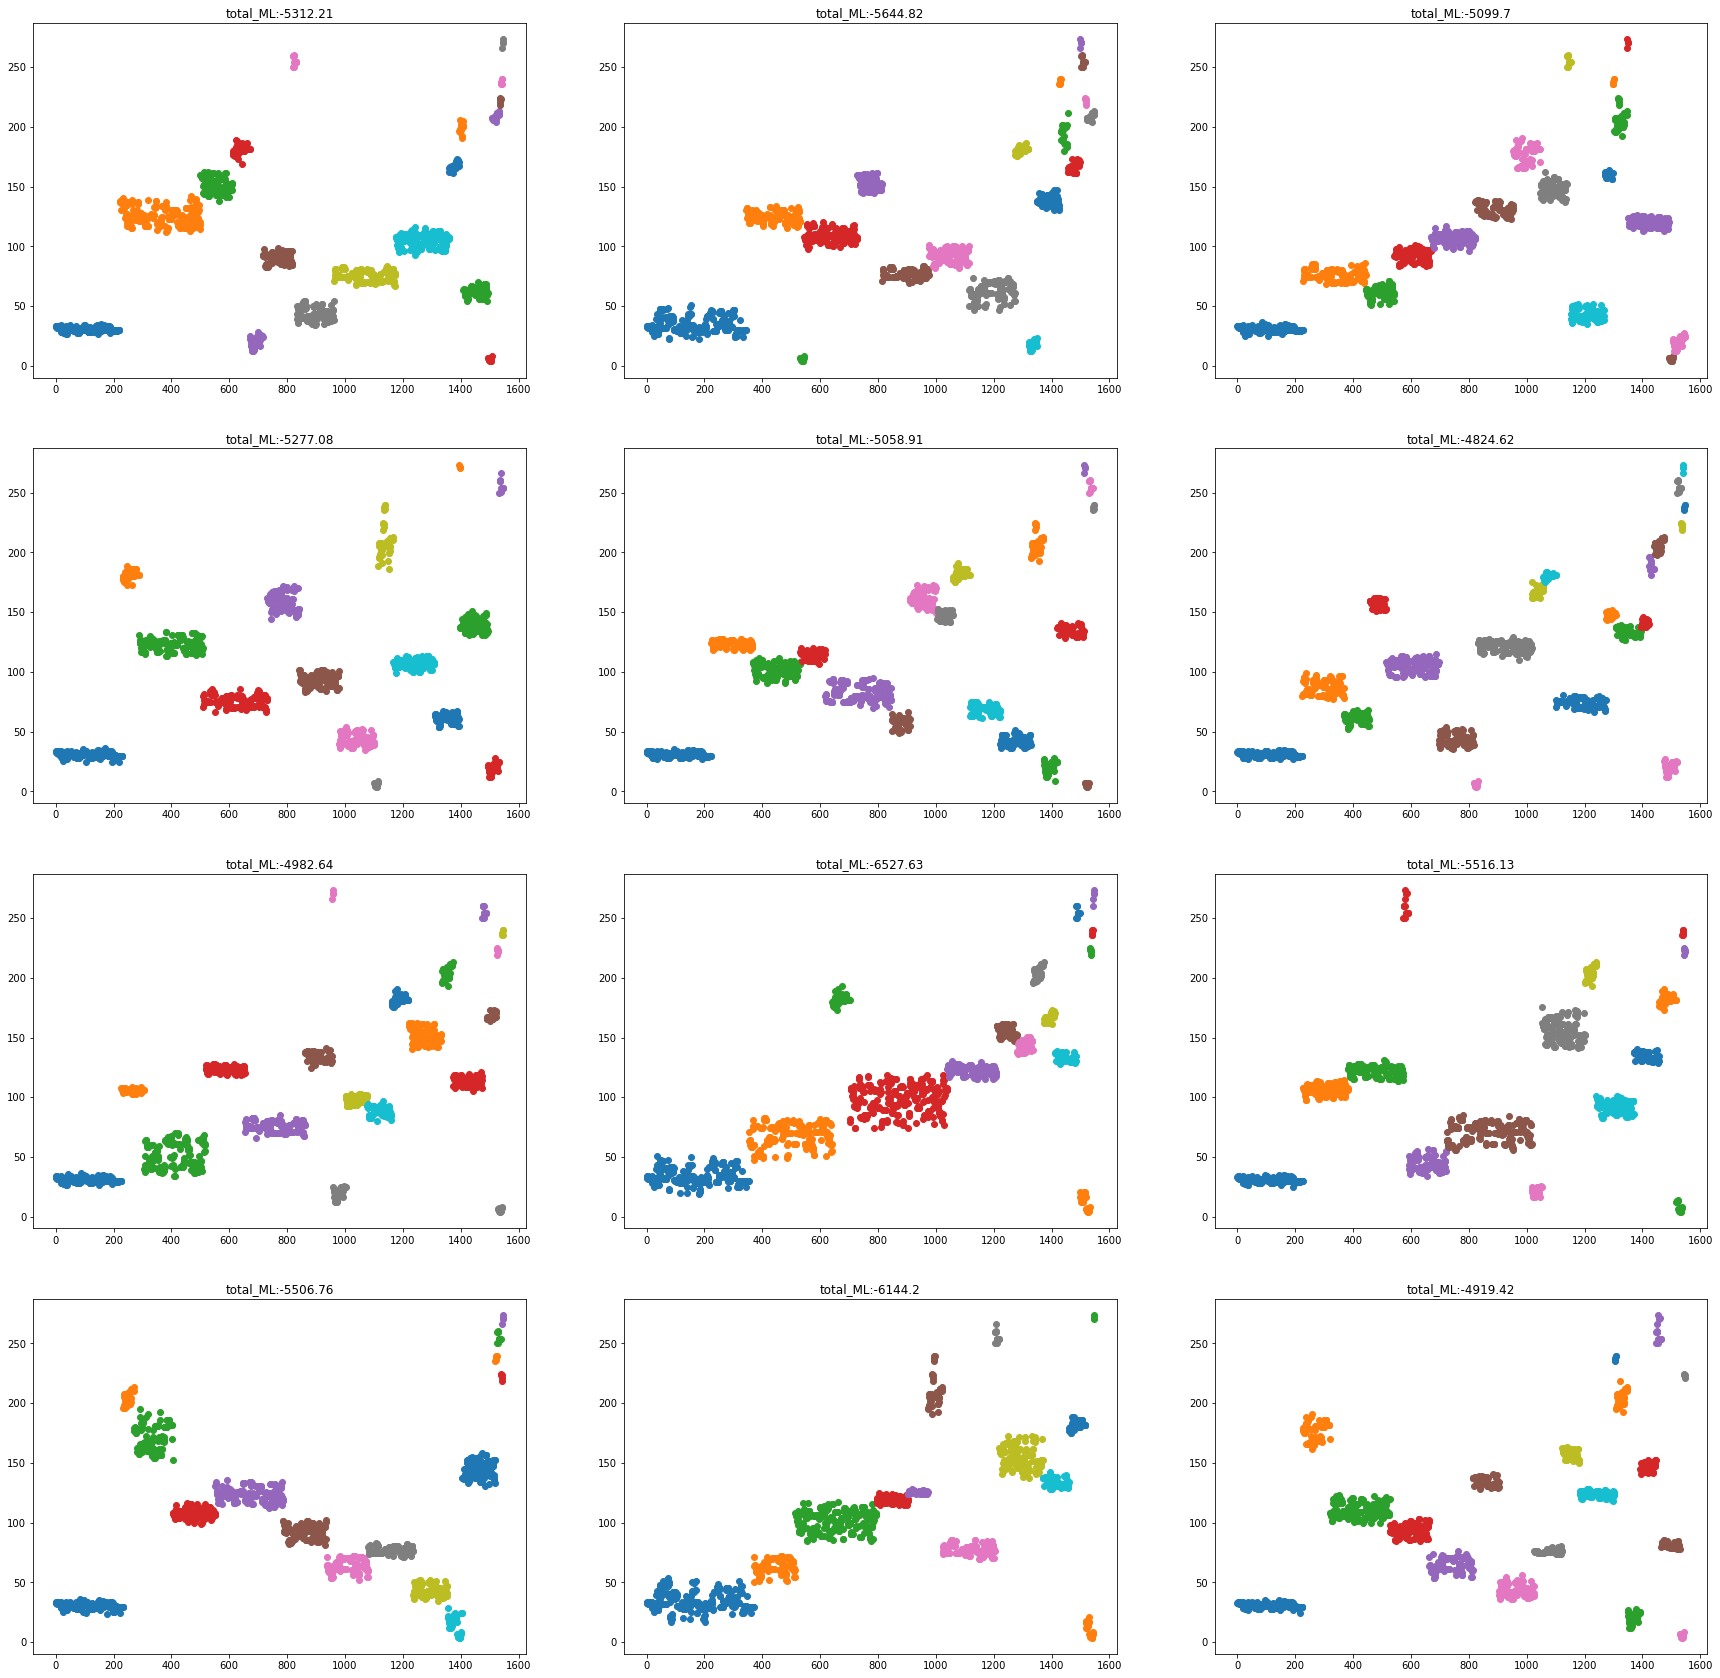

In [238]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [239]:
a_cov_dp = best_a_cov_dp

In [240]:
len(a_cov_dp.cluster_dict)

21

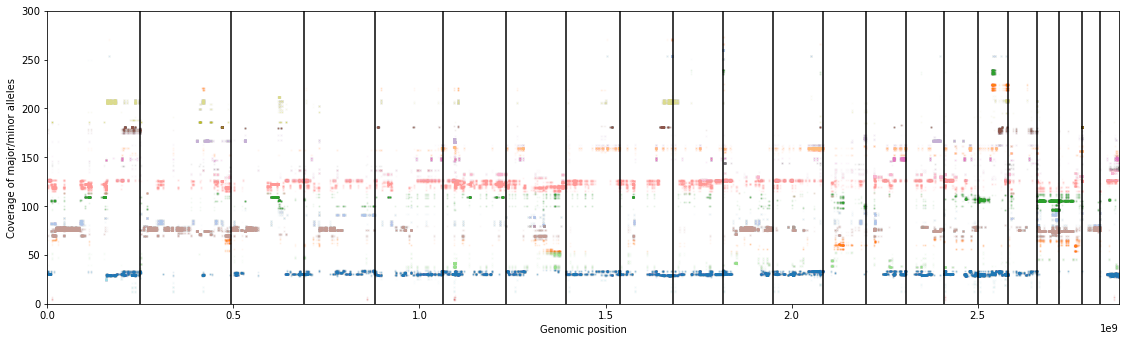

In [241]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

with proper burn in 

In [248]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [249]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [250]:
a_cov_dp.run(1)

n unassigned: 1547
cluster 4 merging with 0
cluster 5 merging with 5
cluster 12 merging with 9
cluster 14 merging with 2
n unassigned: 1426
cluster 18 merging with 0
n unassigned: 1307
n unassigned: 1199
n unassigned: 1098
n unassigned: 1017
n unassigned: 942
n unassigned: 864
n unassigned: 789
n unassigned: 737
n unassigned: 680
n unassigned: 624
n unassigned: 578
cluster 20 merging with 16
n unassigned: 535
n unassigned: 491
n unassigned: 452
n unassigned: 410
n unassigned: 382
n unassigned: 350
n unassigned: 323
n unassigned: 296
n unassigned: 273
n unassigned: 251
n unassigned: 232
n unassigned: 216
n unassigned: 204
n unassigned: 187
n unassigned: 172
n unassigned: 163
n unassigned: 106
n unassigned: 41
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
cluster 22 merging with 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([0, 0, 0, ..., 7, 7, 7])],
 SortedDict({0: 376, 1: 221, 2: 99, 3: 5, 6: 228, 7: 14, 8: 110, 9: 241, 10: 58, 11: 87, 13: 47, 15: 22, 16: 18, 17: 14, 19: 4, 20: 5}))

In [251]:
len(a_cov_dp.cluster_dict)

16

In [252]:
a_cov_dp.ML_total_history[-1]

-6174.48991878474

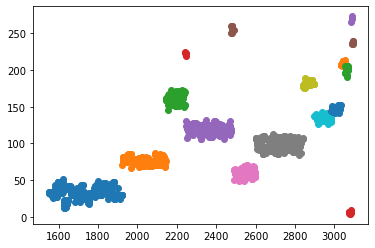

In [253]:
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

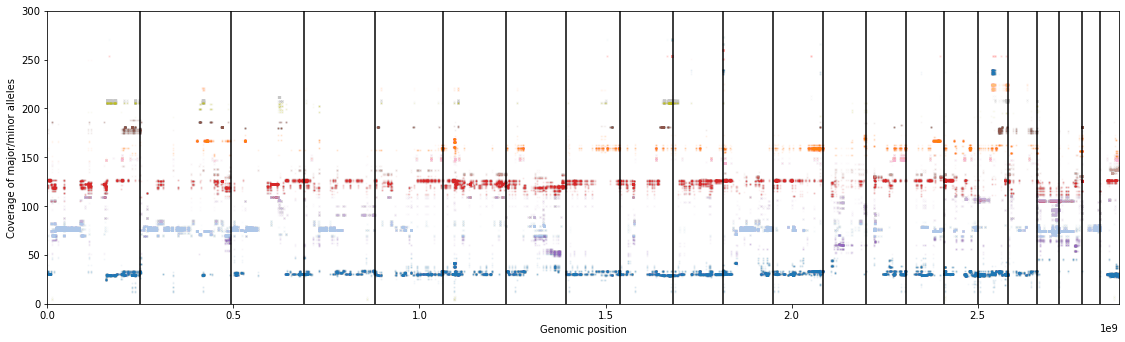

In [254]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

multiple samples with better burnin

n unassigned: 1547
cluster 12 merging with 1
cluster 14 merging with 12
cluster 16 merging with 12
n unassigned: 1426
cluster 18 merging with 12
cluster 20 merging with 1
cluster 21 merging with 14
n unassigned: 1315
n unassigned: 1216
n unassigned: 1117
n unassigned: 1034
cluster 6 merging with 14
n unassigned: 958
n unassigned: 892
n unassigned: 830
n unassigned: 765
n unassigned: 710
n unassigned: 645
n unassigned: 595
n unassigned: 551
n unassigned: 503
n unassigned: 473
n unassigned: 440
n unassigned: 404
cluster 23 merging with 9
n unassigned: 371
cluster 24 merging with 10
n unassigned: 338
n unassigned: 313
n unassigned: 288
n unassigned: 267
cluster 25 merging with 13
n unassigned: 249
n unassigned: 230
n unassigned: 205
n unassigned: 182
n unassigned: 168
n unassigned: 132
n unassigned: 68
n unassigned: 8
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned:

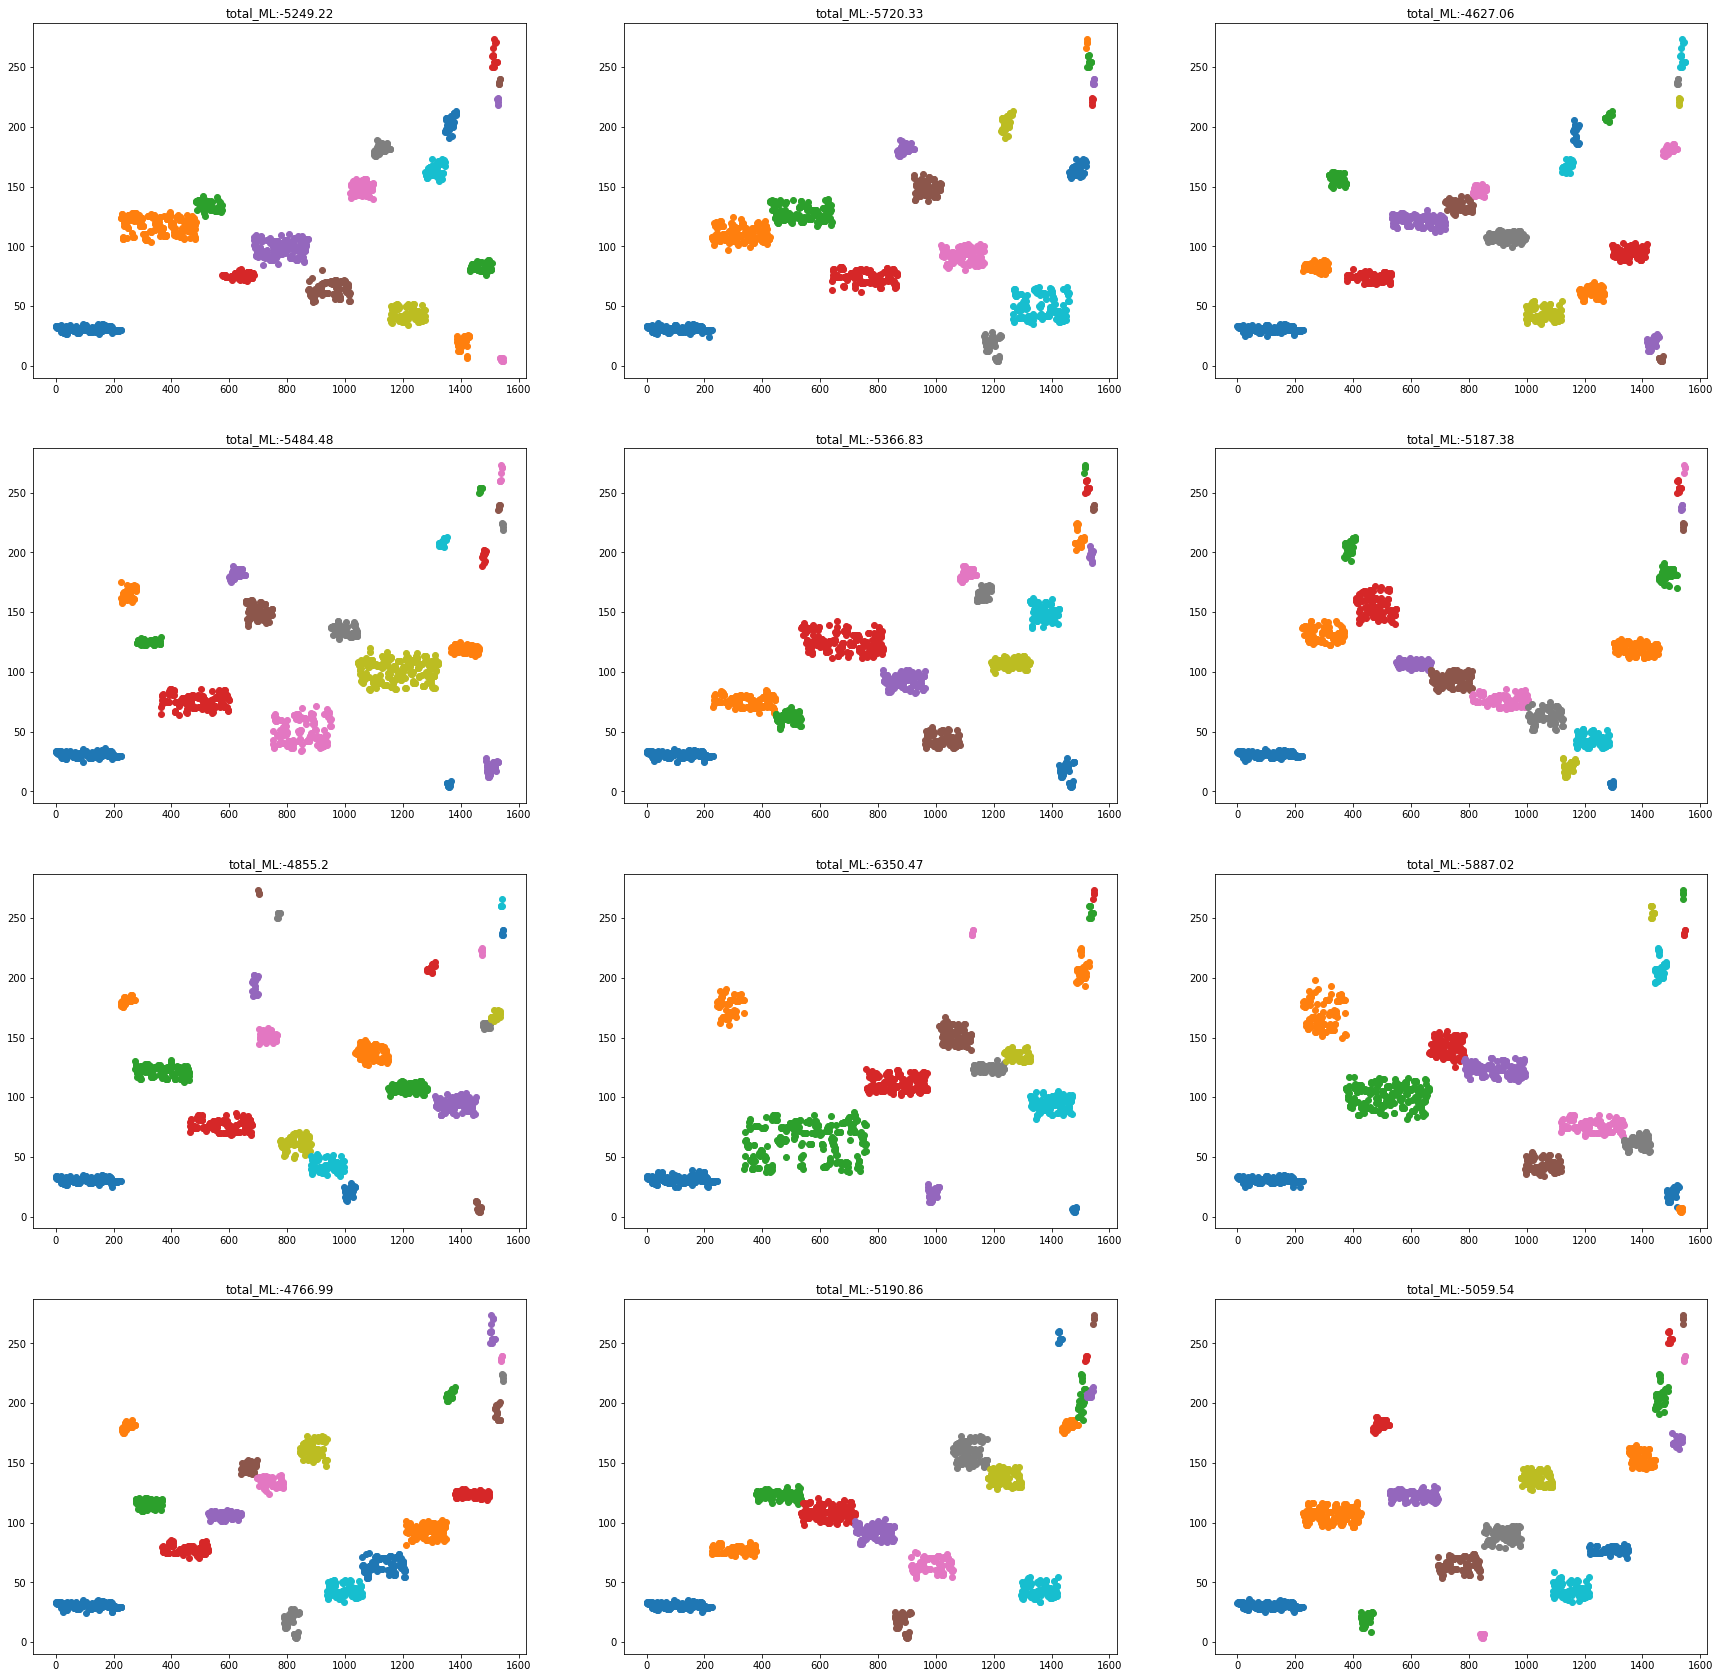

In [255]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [256]:
a_cov_dp = best_a_cov_dp

In [257]:
len(a_cov_dp.cluster_dict)

20

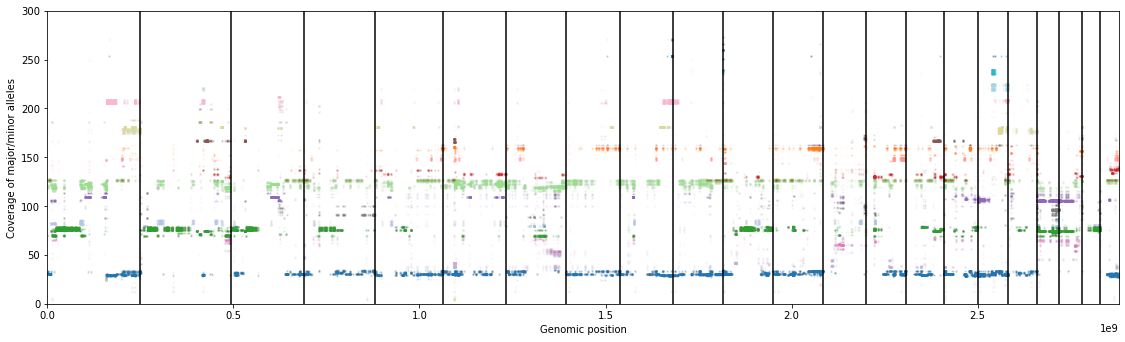

In [258]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

V3 variance

In [425]:
V1_list = []
V2_list = []
V3_list = []
r_list = []
name_list = []
glen_list = []
fallback_counts = sc.SortedDict({})
for ID, (name, grouped) in enumerate(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele'])):
    mu_lst = []
    sigma_lst = []
    a_lst = []
    b_lst = []
    for draw, tup in grouped.groupby('dp_draw'):
        mu = tup['cov_DP_mu'].values[0]
        sigma = tup['cov_DP_sigma'].values[0]
        mu_lst.append(mu)
        sigma_lst.append(sigma)
        group_len = len(tup)
        if group_len > 10:
            major, minor =  (tup['maj_count'].sum(), tup['min_count'].sum())
        else:
            ADP_clust = tup['allelic_cluster'].values[0]
            if ADP_clust in fallback_counts:
                major, minor = fallback_counts[ADP_clust]
            else:
                filt = a_cov_dp.cov_df.loc[a_cov_dp.cov_df.allelic_cluster == ADP_clust]
                major, minor = filt['maj_count'].sum(), filt['min_count'].sum()
                fallback_counts[ADP_clust] = (major, minor)

        allele = tup.allele.values[0]

        if allele== -1:
            f = minor / (minor + major)
            a = minor; b= major
        else:
            f =  major / (minor + major)
            a = major;b=minor
        a_lst.append(a)
        b_lst.append(b)
        
        r = np.exp(mu) * f

        C = np.c_[np.log(tup["C_len"]), tup["C_RT_z"], tup["C_GC_z"]]
        x = tup['covcorr'].values

        V1 = np.exp(np.log(x) - mu - (C @ a_cov_dp.beta).flatten()).var()
        V2 = (np.exp(stats.norm.rvs(mu, sigma, size=10000)) * stats.beta.rvs(a,b, size=10000)).var()
        r_list.append(r)
        name_list.append((name[0], name[1], name[2], draw))
        V1_list.append(V1)
        V2_list.append(V2)
        glen_list.append(group_len)
    
    mus = np.array(mu_lst)
    sigmas = np.array(sigma_lst)
    a_arr = np.array(a_lst)
    b_arr = np.array(b_lst)
    
    draws = np.random.randint(len(mu_lst),size=10000)
    mu_draws = mus[draws]
    sigma_draws = sigmas[draws]
    a_draws = a_arr[draws]
    b_draws = b_arr[draws]
    V3 = (np.exp(stats.norm.rvs(mu_draws, sigma_draws)) * stats.beta.rvs(a_draws,b_draws)).var()
    
    V3_list.extend([V3]*len(mus))

In [426]:
var_df2 = pd.DataFrame({'r':r_list, 'V1':V1_list, 'V2':V2_list, 'V3':V3_list, 'glen':glen_list}, index=pd.MultiIndex.from_tuples(name_list, names=['ADP', 'CDP', 'allele', 'dp_draw']))

In [435]:
var_df2

r        V1        V2         V3  glen
ADP CDP allele dp_draw                                                 
0   0   -1     0         33.069894  0.040220  0.140961   0.595726    85
               1         33.724506  0.035659  0.067152   0.595726   185
               2         32.634887  0.031547  0.079819   0.595726   162
               3         32.395408  0.029184  0.141984   0.595726    92
               4         31.923877  0.029168  0.081952   0.595726   153
...                            ...       ...       ...        ...   ...
18  11   1     4        271.314452  0.028126  0.470607  49.344898    29
               5        254.161478  0.035535  0.317953  49.344898    41
               6        254.161478  0.035535  0.320535  49.344898    41
               7        254.161478  0.035535  0.321273  49.344898    41
               8        254.161478  0.035535  0.318963  49.344898    41

[1592 rows x 5 columns]

In [436]:
var_df2.groupby(level=['ADP','CDP','allele']).agg({'V3':np.mean, 'glen':np.mean})

V3         glen
ADP CDP allele                          
0   0   -1         0.595726   152.400000
         1         2.895754   152.400000
    1   -1         0.116445   482.300000
         1         1.651825   482.300000
    3   -1         1.583294    58.333333
         1         6.898699    58.333333
    4   -1         0.153628     2.000000
         1         3.746265     2.000000
    7   -1         1.841891    55.857143
         1         6.856153    55.857143
    8   -1        20.238962    17.333333
         1        12.205600    17.333333
    11  -1         0.141547     2.500000
         1         3.416509     2.500000
    12  -1         0.358474    43.666667
         1         0.407100    43.666667
    15  -1        36.910256     2.000000
         1       885.176382     2.000000
    22  -1        12.934726     4.000000
         1       318.422021     4.000000
    25  -1         8.290481     4.000000
         1       208.138172     4.000000
    30  -1         0.605979     4.000000
         1        14.879922     4.000000
1   0   -1         8.432215     9.000000
         1        10.556705     9.000000
    1   -1         1.249163    36.000000
         1        28.052005    36.000000
    2   -1         9.940002    15.200000
         1       108.462322    15.200000
    3   -1         0.137625     8.000000
         1         0.708301     8.000000
    4   -1        54.761509    27.400000
         1       176.740944    27.400000
    5   -1         0.060165   214.600000
         1         0.081197   214.600000
    6   -1         0.017751     6.750000
         1         0.089670     6.750000
    7   -1         3.214467    71.700000
         1         4.672538    71.700000
    8   -1         0.162171   178.900000
         1         0.277516   178.900000
    11  -1         7.363022    22.200000
         1        18.693739    22.200000
    12  -1         1.712458    44.000000
         1        13.572717    44.000000
    21  -1         4.901171    15.000000
         1        63.248283    15.000000
    22  -1         4.682702     2.000000
         1        24.361019     2.000000
    25  -1        17.291767     4.000000
         1        90.546895     4.000000
    30  -1         2.005439     2.000000
         1        10.242878     2.000000
2   0   -1         0.010164     3.000000
         1         0.010258     3.000000
    1   -1         0.008539     9.000000
         1         0.008652     9.000000
    3   -1         0.005396     3.000000
         1         0.005456     3.000000
    4   -1         4.325622    19.600000
         1        39.267495    19.600000
    12  -1         0.005527     3.000000
         1         0.005450     3.000000
    15  -1        14.479166     4.000000
         1      1041.601807     4.000000
    22  -1         5.120982     7.000000
         1       372.581143     7.000000
    25  -1         3.819200     7.333333
         1       775.006243     7.333333
    30  -1         0.245906     9.000000
         1        17.303302     9.000000
3   0   -1         2.194521    43.400000
         1         8.070779    43.400000
    1   -1         3.973169    22.333333
         1        46.874489    22.333333
    3   -1         0.058295  1002.900000
         1         2.085999  1002.900000
    4   -1         2.987154    19.200000
         1        81.290941    19.200000
    5   -1         0.003062    10.000000
         1         0.051294    10.000000
    6   -1         0.218963    79.400000
         1         2.787541    79.400000
    7   -1         9.635902    47.400000
         1        48.784298    47.400000
    12  -1         0.314912   661.555556
         1         4.870418   661.555556
    21  -1         7.819823    10.000000
         1        61.226842    10.000000
    22  -1        17.172030     4.000000
         1       290.589426     4.000000
    25  -1        11.356412     3.333333
         1       193.259503     3.333333
    30  -1         0.803894     4.000000
         1        13.608641     4.000000
4   0  

Text(0.5, 0, 'log empirical var')

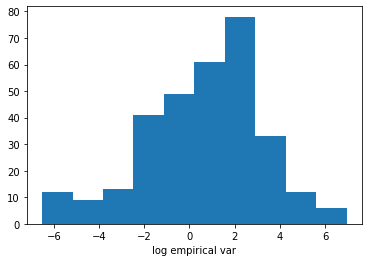

In [467]:
_ = plt.hist(np.log(var_df2.groupby(level=['ADP','CDP','allele']).agg({'V3':np.mean}).V3.values))
plt.xlabel('log empirical var')

In [443]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [451]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [452]:
a_cov_dp.run(1)

n unassigned: 1557
n unassigned: 1443
n unassigned: 1332
n unassigned: 1239
n unassigned: 1154
n unassigned: 1065
n unassigned: 972
n unassigned: 897
n unassigned: 831
n unassigned: 765
n unassigned: 706
n unassigned: 649
n unassigned: 596
n unassigned: 548
n unassigned: 504
n unassigned: 464
n unassigned: 430
n unassigned: 408
n unassigned: 366
n unassigned: 334
n unassigned: 308
n unassigned: 283
n unassigned: 261
n unassigned: 237
n unassigned: 216
n unassigned: 195
n unassigned: 176
n unassigned: 164
n unassigned: 118
n unassigned: 51
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([5, 0, 0, ..., 4, 4, 4])],
 SortedDict({0: 81, 1: 129, 2: 176, 3: 50, 4: 23, 5: 170, 7: 35, 8: 98, 9: 58, 10: 145, 11: 76, 12: 150, 13: 45, 14: 100, 17: 157, 22: 59, 29: 7}))

In [453]:
len(a_cov_dp.cluster_dict)

17

In [454]:
a_cov_dp.ML_total_history[-1]

-4962.380007497933

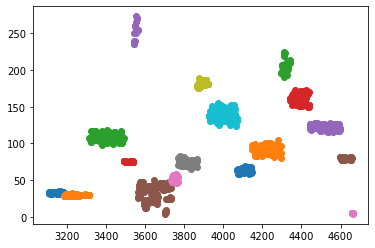

In [455]:
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

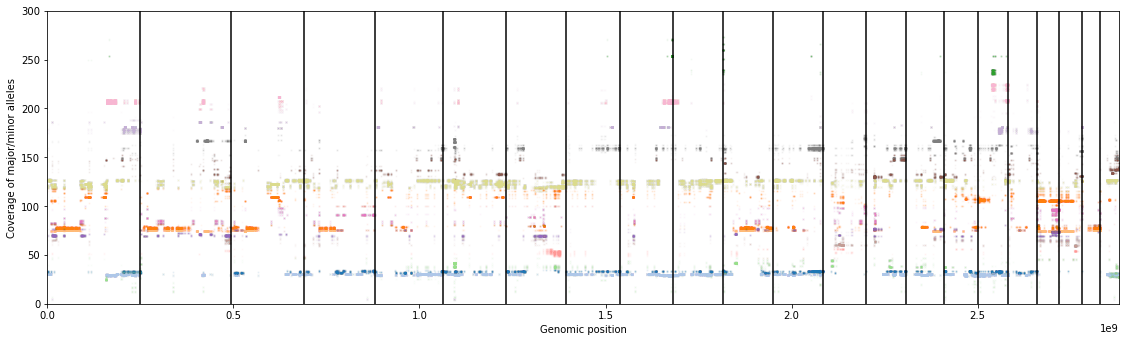

In [457]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

n unassigned: 1557
n unassigned: 1423
n unassigned: 1308
n unassigned: 1211
n unassigned: 1114
n unassigned: 1042
n unassigned: 961
n unassigned: 889
n unassigned: 830
n unassigned: 766
n unassigned: 700
n unassigned: 645
n unassigned: 591
n unassigned: 545
n unassigned: 503
n unassigned: 468
n unassigned: 438
n unassigned: 408
n unassigned: 380
n unassigned: 364
n unassigned: 337
n unassigned: 312
n unassigned: 283
n unassigned: 266
n unassigned: 240
n unassigned: 219
n unassigned: 196
n unassigned: 180
n unassigned: 167
n unassigned: 146
n unassigned: 75
n unassigned: 16
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned:

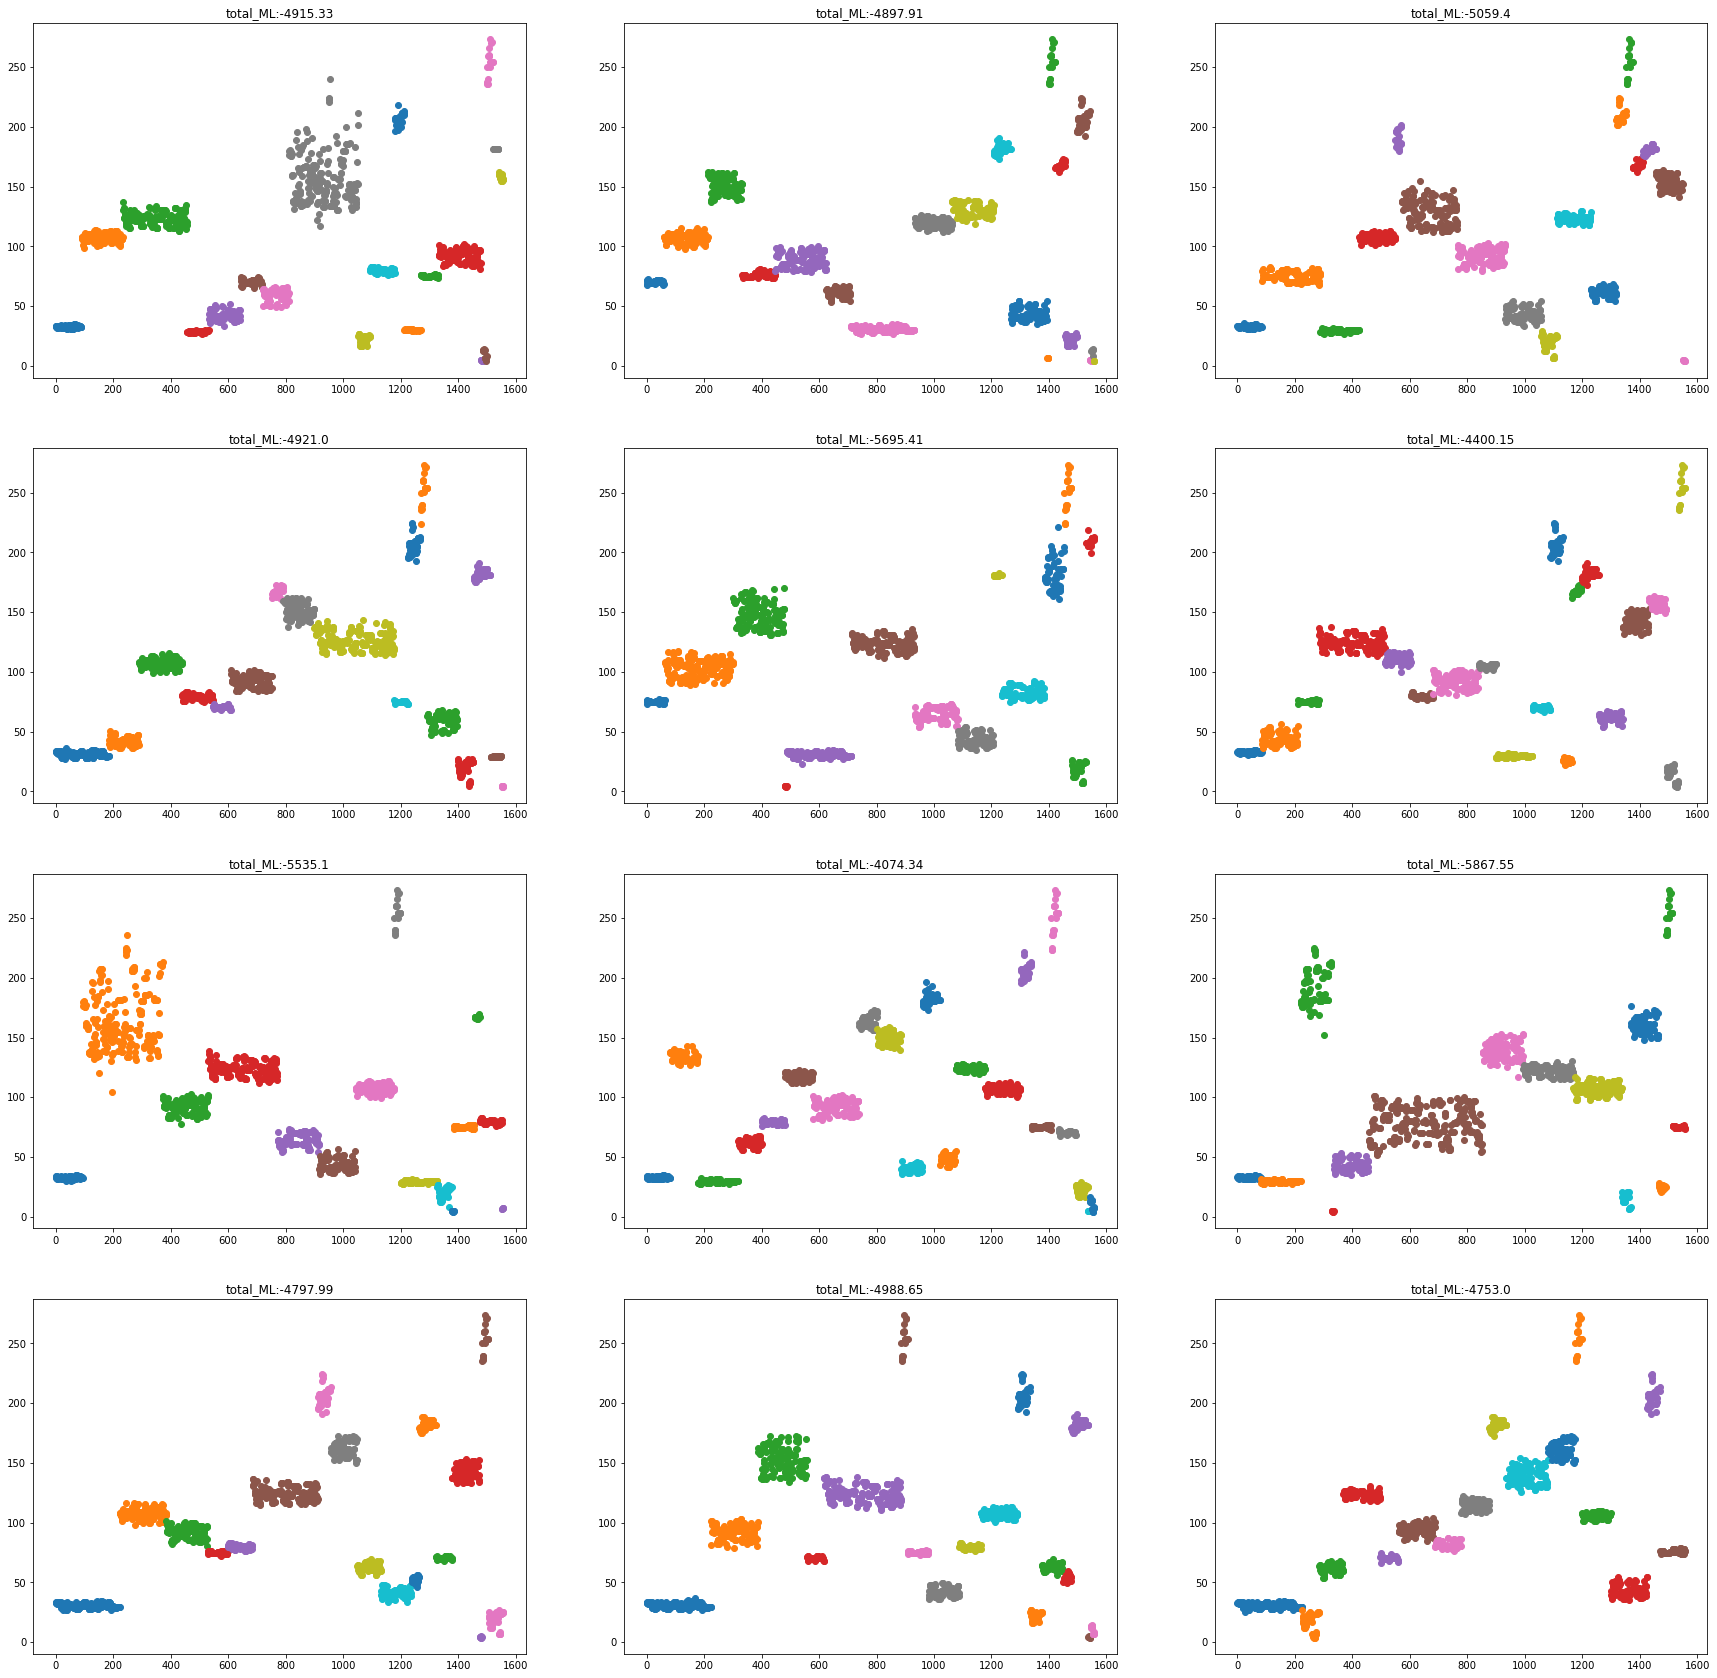

In [458]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [462]:
a_cov_dp = best_a_cov_dp

In [463]:
len(a_cov_dp.cluster_dict)

21

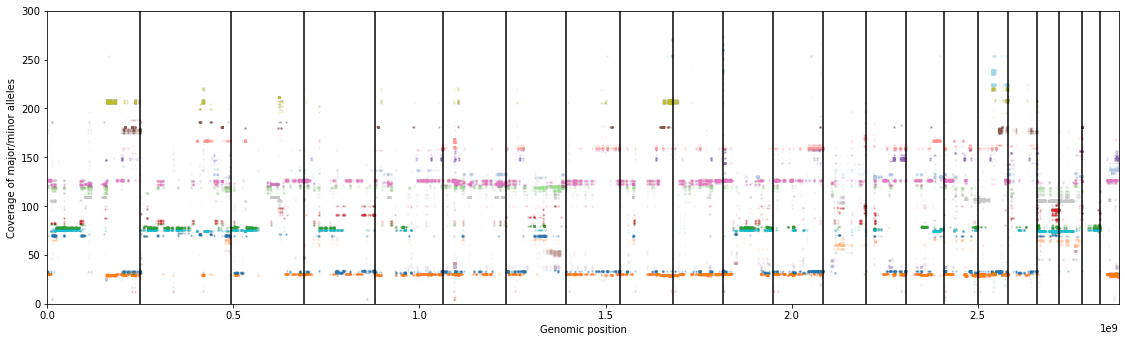

In [464]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [479]:
a_cov_dp.segment_V_list[169]

173.48448811249725

In [ ]:
a_cov_dp.segment_V_list